In [2]:
# Imports.
import json
import sys
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import expit, logit
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
# Configuration

sns.set_theme(style="white", font_scale=2.1)

STUDY1_CSV = Path("game_trials_export_v1.csv")
STUDY2_CSV = Path("game_trials_export.csv")
STUDY1_PROLIFIC_CSV = Path("prolific_export_n20.csv")
STUDY2_PROLIFIC_CSV = Path("prolific_export_n30.csv")
SUBJECT_COL = "prolificId"
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
OPTIMAL_ROUTE_COL = "optimalRoute"
WORRY_COL = "worry"
SOMA_COL = "somatic_anxiety"
PARTICIPANT_ID_COL = "participant_id"

# Study 1 mappings (cars and trucks)
car_up = {"e", "c"}
all_truck_up = {"t", "b"}
small_car_lr = {"q", "w"}
big_car_lr = {"z", "x"}
truck_lr = {"n", "m"}
pickup_truck_lr = {"y", "u"}

STUDY1_VALID_KEYS = {
    "small_car": small_car_lr | car_up,
    "big_car": big_car_lr | car_up,
    "truck": truck_lr | all_truck_up,
    "pickup_truck": pickup_truck_lr | all_truck_up,
    "medium_car": small_car_lr | big_car_lr | car_up,
    "dump_truck": truck_lr | pickup_truck_lr | all_truck_up,
}

STUDY1_UNIVERSAL_KEY_MAP = {
    'e': 'up', 'c': 'down', 't': 'up', 'b': 'down',
    'q': 'left', 'w': 'right', 'z': 'left', 'x': 'right',
    'n': 'left', 'm': 'right', 'y': 'left', 'u': 'right'
}

# Study 2 mappings (sedans)
STUDY2_VALID_KEYS = {
    "small_car": ["a", "d", "w", "x"],
    "big_car": ["s", "f", "e", "c"],
    "medium_car": ["a", "s", "d", "f", "w", "e", "x", "c"],
    "small_sedan": ["g", "j", "y", "n"],
    "big_sedan": ["h", "k", "u", "m"],
    "medium_sedan": ["g", "h", "j", "k", "y", "u", "n", "m"],
}

STUDY2_UNIVERSAL_KEY_MAP = {
    'w': 'up', 'e': 'up', 'y': 'up', 'u': 'up',
    'x': 'down', 'c': 'down', 'n': 'down', 'm': 'down',
    'a': 'left', 's': 'left', 'g': 'left', 'h': 'left',
    'd': 'right', 'f': 'right', 'j': 'right', 'k': 'right',
}

CHANCE_PERFORMANCE = 1 / (4**4)

In [9]:
def parse_plan(seq):
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def parse_optimal_route(json_str):
    try:
        return [direction.lower() for direction in json.loads(json_str)]
    except (json.JSONDecodeError, TypeError):
        return []

def calculate_exact_match_accuracy(row, key_map):
    optimal_dirs = parse_optimal_route(row[OPTIMAL_ROUTE_COL])
    plan_keys = str(row[PLAN_COL]) if pd.notna(row[PLAN_COL]) else ""
    if not optimal_dirs or not plan_keys:
        return np.nan
    participant_dirs = [key_map.get(key, 'unknown') for key in plan_keys.lower()]
    return 1.0 if participant_dirs == optimal_dirs else 0.0

def analyse_subj(df_subj, valid_keys):
    """
    Analyzes a subject's trial data to compute under-generalization metrics.
    Returns prop_toward (for dangerous trials) and prop_toward_nd (for non-dangerous trials).
    """
    if df_subj.empty:
        return {}

    first_row = df_subj.iloc[0]
    participant_id = first_row[PARTICIPANT_ID_COL]
    dangerous_vehicle = first_row[DANGEROUS_COL]
    danger_keys = set(valid_keys.get(dangerous_vehicle, []))

    dangerous_vehicle_mismatches = 0
    dangerous_vehicle_total_items = 0
    nondangerous_invalid_away_from_danger = 0
    nondangerous_invalid_total = 0

    for _, row in df_subj.iterrows():
        plan_items = parse_plan(row[PLAN_COL])
        current_vehicle = row[VEHICLE_COL]

        if current_vehicle == dangerous_vehicle:
            for item in plan_items:
                if item not in danger_keys:
                    dangerous_vehicle_mismatches += 1
            dangerous_vehicle_total_items += len(plan_items)
        else:
            valid_keys_for_row = set(valid_keys.get(current_vehicle, []))
            for item in plan_items:
                if item not in valid_keys_for_row:
                    nondangerous_invalid_total += 1
                    if item not in danger_keys:
                        nondangerous_invalid_away_from_danger += 1

    prop_mismatch_dangerous = (dangerous_vehicle_mismatches / dangerous_vehicle_total_items) if dangerous_vehicle_total_items > 0 else 0
    prop_away_nondangerous_invalid = (nondangerous_invalid_away_from_danger / nondangerous_invalid_total) if nondangerous_invalid_total > 0 else 0
    total_mistakes = dangerous_vehicle_mismatches + nondangerous_invalid_total

    return {
        PARTICIPANT_ID_COL: participant_id,
        WORRY_COL: first_row[WORRY_COL],
        SOMA_COL: first_row.get(SOMA_COL, np.nan),
        'age': first_row.get('age', np.nan),
        'gender': first_row.get('gender', np.nan),
        'total_mistakes': total_mistakes,
        "prop_toward": prop_mismatch_dangerous,
        "prop_toward_nd": prop_away_nondangerous_invalid
    }

def filter_subjects_by_key_coverage(df, min_categories, valid_keys):
    """Filter participants who don't use keys from at least min_categories."""
    key_to_categories = {}
    for cat, keys in valid_keys.items():
        for k in keys:
            key_to_categories.setdefault(k, set()).add(cat)

    coverage_rows = []
    for pid, grp in df.groupby(PARTICIPANT_ID_COL, sort=False):
        keys_used = set()
        for seq in grp[PLAN_COL]:
            keys_used.update(parse_plan(seq))

        cats_covered = set()
        for k in keys_used:
            cats_covered.update(key_to_categories.get(k, []))

        coverage_rows.append({
            PARTICIPANT_ID_COL: pid,
            'n_categories_by_keys': len(cats_covered),
        })

    coverage_df = pd.DataFrame(coverage_rows)
    keep_ids = coverage_df.loc[coverage_df['n_categories_by_keys'] >= min_categories, PARTICIPANT_ID_COL]

    before = df[PARTICIPANT_ID_COL].nunique()
    filtered_df = df[df[PARTICIPANT_ID_COL].isin(keep_ids)].copy()
    after = filtered_df[PARTICIPANT_ID_COL].nunique()

    print(f"Category coverage filter: {before} -> {after} participants")
    return filtered_df, coverage_df

def plot_correlation_with_outliers(df, x_col, y_col, x_label, y_label, title, filename, one_tailed=False):
    """
    Plot correlation with and without outliers (>2 SD from mean on x-axis).
    """
    print(f"\n--- Plotting Correlation: {title} ---")
    sub_df = df[[x_col, y_col]].dropna()

    if len(sub_df) < 3:
        print(f"Not enough data to plot {title}.")
        return

    # Calculate outliers
    x_mean = sub_df[x_col].mean()
    x_std = sub_df[x_col].std()
    threshold = 2
    lower_bound = x_mean - threshold * x_std
    upper_bound = x_mean + threshold * x_std

    # Filter outliers
    sub_df_no_outliers = sub_df[(sub_df[x_col] >= lower_bound) & (sub_df[x_col] <= upper_bound)]
    outliers = sub_df[(sub_df[x_col] < lower_bound) | (sub_df[x_col] > upper_bound)]

    # Compute correlations (two-tailed)
    spearman_all, p_all_two = stats.spearmanr(sub_df[x_col], sub_df[y_col])
    p_all = p_all_two / 2.0 if one_tailed else p_all_two

    if len(sub_df_no_outliers) >= 3:
        spearman_no_outliers, p_no_outliers_two = stats.spearmanr(
            sub_df_no_outliers[x_col], sub_df_no_outliers[y_col]
        )
        p_no_outliers = p_no_outliers_two / 2.0 if one_tailed else p_no_outliers_two
    else:
        spearman_no_outliers, p_no_outliers = np.nan, np.nan

    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Left plot: All data
    sns.regplot(data=sub_df, x=x_col, y=y_col, robust=True, ax=ax1)
    if len(outliers) > 0:
        ax1.scatter(outliers[x_col], outliers[y_col], color='red', s=100,
                   marker='x', linewidths=3, label=f'Outliers (>2 SD, n={len(outliers)})', zorder=5)
        ax1.legend()
    ax1.set_xlabel(x_label, fontsize=28)
    ax1.set_ylabel(y_label, fontsize=20)
    annotation = f"All data: ρ = {spearman_all:.2f}, p = {p_all/2.0:.3f}"
    ax1.set_title(annotation, fontsize=24, weight='bold')

    # Right plot: Without outliers
    if len(sub_df_no_outliers) >= 3:
        sns.regplot(data=sub_df_no_outliers, x=x_col, y=y_col, robust=True, ax=ax2)
        ax2.set_xlabel(x_label, fontsize=28)
        ax2.set_ylabel(y_label, fontsize=20)
        annotation = f"Without outliers: ρ = {spearman_no_outliers:.2f}, p = {p_no_outliers/2.0:.3f}"
        ax2.set_title(annotation, fontsize=24, weight='bold')
    else:
        ax2.text(0.5, 0.5, 'Not enough data\nwithout outliers',
                ha='center', va='center', transform=ax2.transAxes, fontsize=16)
        ax2.set_xlabel(x_label, fontsize=28)
        ax2.set_ylabel(y_label, fontsize=20)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Correlation plot saved to '{filename}'")

    # Print summary
    tail_type = "one-tailed" if one_tailed else "two-tailed"
    print(f"  All data (n={len(sub_df)}): ρ = {spearman_all:.3f}, p = {p_all:.3f} ({tail_type})")
    print(f"  Without outliers (n={len(sub_df_no_outliers)}): ρ = {spearman_no_outliers:.3f}, p = {p_no_outliers:.3f} ({tail_type})")
    print(f"  Number of outliers removed: {len(outliers)}")
    print(f"  Outlier threshold: {x_mean:.2f} ± {threshold}*{x_std:.2f} = [{lower_bound:.2f}, {upper_bound:.2f}]")

    return spearman_all, p_all, spearman_no_outliers, p_no_outliers

def compute_valid_key_usage_difference(csv_path, prolific_csv, valid_keys, key_map, study_name, min_categories=0):
    """
    Compute the differential impact metric: valid_key_usage_difference.
    This measures: avg_valid_keys_in_dangerous_trials - avg_valid_keys_in_safe_trials
    """
    print(f"\nComputing valid key usage difference for {study_name}...")

    if not csv_path.exists():
        print(f"Error: Data file not found at '{csv_path}'")
        return None

    df = pd.read_csv(csv_path)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    # Load demographics
    if prolific_csv.exists():
        prolific_df = pd.read_csv(prolific_csv)
        prolific_df = prolific_df[['Participant id', 'Age', 'Sex']].copy()
        prolific_df.columns = [SUBJECT_COL, 'age', 'gender']
        df_phase2 = df_phase2.merge(prolific_df, on=SUBJECT_COL, how='left')

    # Simplify participant IDs
    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)

    # Filter by planning accuracy
    df_phase2['exact_match_accuracy'] = df_phase2.apply(
        lambda row: calculate_exact_match_accuracy(row, key_map), axis=1
    )
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean()
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['exact_match_accuracy'] < accuracy_threshold].index.tolist()

    if low_accuracy_subjects:
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(low_accuracy_subjects)].copy()

    # Filter by key coverage if requested
    if min_categories > 0:
        df_phase2, _ = filter_subjects_by_key_coverage(df_phase2, min_categories, valid_keys)

    # Count valid key usage per trial
    def count_valid_keys(row):
        plan = parse_plan(row[PLAN_COL])
        vehicle_type = row[VEHICLE_COL]
        allowed_keys = set(valid_keys.get(vehicle_type, []))
        if not allowed_keys:
            return 0
        return sum(1 for key in plan if key in allowed_keys)

    df_phase2['valid_key_usage'] = df_phase2.apply(count_valid_keys, axis=1)

    # Compute difference per participant
    results = []
    for pid, grp in df_phase2.groupby(PARTICIPANT_ID_COL):
        dangerous_vehicle = grp[DANGEROUS_COL].iloc[0]
        worry_score = grp[WORRY_COL].iloc[0]

        dangerous_trials = grp[grp[VEHICLE_COL] == dangerous_vehicle]
        safe_trials = grp[grp[VEHICLE_COL] != dangerous_vehicle]

        avg_usage_dangerous = dangerous_trials['valid_key_usage'].mean() if not dangerous_trials.empty else np.nan
        avg_usage_safe = safe_trials['valid_key_usage'].mean() if not safe_trials.empty else np.nan

        usage_difference = avg_usage_dangerous - avg_usage_safe

        results.append({
            PARTICIPANT_ID_COL: pid,
            WORRY_COL: worry_score,
            'age': grp['age'].iloc[0] if 'age' in grp.columns else np.nan,
            'gender': grp['gender'].iloc[0] if 'gender' in grp.columns else np.nan,
            'valid_key_usage_difference': usage_difference
        })

    result_df = pd.DataFrame(results)
    print(f"  Computed for {len(result_df)} participants")

    return result_df

def process_study(csv_path, prolific_csv, valid_keys, key_map, study_name, min_categories=4):
    """
    Process one study's data and return the summary dataframe.
    """
    print(f"\n{'='*60}")
    print(f"Processing {study_name}")
    print(f"{'='*60}\n")

    if not csv_path.exists():
        print(f"Error: Data file not found at '{csv_path}'")
        return None

    print(f"Loading data from '{csv_path}'...")
    df = pd.read_csv(csv_path)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    # Load prolific demographics data
    if prolific_csv.exists():
        print(f"Loading demographics from '{prolific_csv}'...")
        prolific_df = pd.read_csv(prolific_csv)
        # Merge demographics (age, sex) with trial data
        prolific_df = prolific_df[['Participant id', 'Age', 'Sex']].copy()
        prolific_df.columns = [SUBJECT_COL, 'age', 'gender']
        df_phase2 = df_phase2.merge(prolific_df, on=SUBJECT_COL, how='left')
        print(f"  Demographics merged: {df_phase2['age'].notna().sum()} participants with age data")
    else:
        print(f"  Warning: Demographics file not found at '{prolific_csv}'")

    # Simplify participant IDs
    unique_ids = df_phase2[SUBJECT_COL].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}
    df_phase2[PARTICIPANT_ID_COL] = df_phase2[SUBJECT_COL].map(id_map)
    print(f"Loaded {len(unique_ids)} participants")

    # Filter by planning accuracy
    df_phase2['exact_match_accuracy'] = df_phase2.apply(
        lambda row: calculate_exact_match_accuracy(row, key_map), axis=1
    )
    accuracy_df = df_phase2.groupby(PARTICIPANT_ID_COL)[['exact_match_accuracy']].mean()
    accuracy_threshold = 0.01
    low_accuracy_subjects = accuracy_df[accuracy_df['exact_match_accuracy'] < accuracy_threshold].index.tolist()

    if low_accuracy_subjects:
        print(f"Removing {len(low_accuracy_subjects)} participants with accuracy < {accuracy_threshold:.0%}")
        df_phase2 = df_phase2[~df_phase2[PARTICIPANT_ID_COL].isin(low_accuracy_subjects)].copy()
        accuracy_df = accuracy_df[~accuracy_df.index.isin(low_accuracy_subjects)]

    # Filter by key coverage
    df_phase2, _ = filter_subjects_by_key_coverage(df_phase2, min_categories, valid_keys)
    remaining_ids = set(df_phase2[PARTICIPANT_ID_COL].unique())
    accuracy_df = accuracy_df[accuracy_df.index.isin(remaining_ids)]

    print(f"Final participant count: {len(remaining_ids)}")

    # Compute under-generalization metrics
    records = [analyse_subj(grp, valid_keys) for _, grp in df_phase2.groupby(PARTICIPANT_ID_COL)]
    summary_df = pd.DataFrame(records)

    # Merge with accuracy
    accuracy_df = accuracy_df.reset_index()
    final_summary_df = pd.merge(summary_df, accuracy_df, on=PARTICIPANT_ID_COL, suffixes=('_gen', '_acc'))

    return final_summary_df

comment 1.2: correlations without outliers

In [46]:
def redo_correlations():
    """
    Redo all correlations from Study 1 and Study 2, showing with and without outliers.
    Runs analysis for both "all subjects" and "generalizers" (4+ categories).
    """
    print("\n" + "="*60)
    print("TASK 1: Redo correlations without extreme x points (>2 SD)")
    print("="*60)

    results = {}

    # ===== STUDY 1 =====
    # Process Study 1 - ALL SUBJECTS (no category filter)
    print("\n" + "-"*60)
    print("STUDY 1 - ALL SUBJECTS (accuracy filter only)")
    print("-"*60)
    study1_all_df = process_study(STUDY1_CSV, STUDY1_PROLIFIC_CSV, STUDY1_VALID_KEYS,
                                   STUDY1_UNIVERSAL_KEY_MAP, "Study 1 - All Subjects", min_categories=0)

    if study1_all_df is not None:
        print(f"\nStudy 1 All Subjects Correlations (n={len(study1_all_df)}):")

        # Threat context
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study1_all_df, WORRY_COL, 'prop_toward',
            'Worry Score', 'Under-Generalization (Threat)',
            'Study 1 All Subjects: Worry vs Under-Generalization (Threat)',
            'study1_all_worry_vs_prop_toward_outlier_analysis.png'
        )
        results['s1_all_threat'] = (rho, p)

        # Safe context
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study1_all_df, WORRY_COL, 'prop_toward_nd',
            'Worry Score', 'Under-Generalization (Safe)',
            'Study 1 All Subjects: Worry vs Under-Generalization (Safe)',
            'study1_all_worry_vs_prop_toward_nd_outlier_analysis.png'
        )
        results['s1_all_safe'] = (rho, p)

    # Process Study 1 - GENERALIZERS (4+ categories)
    print("\n" + "-"*60)
    print("STUDY 1 - GENERALIZERS (4+ categories)")
    print("-"*60)
    study1_gen_df = process_study(STUDY1_CSV, STUDY1_PROLIFIC_CSV, STUDY1_VALID_KEYS,
                                   STUDY1_UNIVERSAL_KEY_MAP, "Study 1 - Generalizers", min_categories=4)

    if study1_gen_df is not None:
        print(f"\nStudy 1 Generalizers Correlations (n={len(study1_gen_df)}):")

        # Threat context
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study1_gen_df, WORRY_COL, 'prop_toward',
            'Worry Score', 'Under-Generalization (Threat)',
            'Study 1 Generalizers: Worry vs Under-Generalization (Threat)',
            'study1_generalizers_worry_vs_prop_toward_outlier_analysis.png'
        )
        results['s1_gen_threat'] = (rho, p)

        # Safe context
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study1_gen_df, WORRY_COL, 'prop_toward_nd',
            'Worry Score', 'Under-Generalization (Safe)',
            'Study 1 Generalizers: Worry vs Under-Generalization (Safe)',
            'study1_generalizers_worry_vs_prop_toward_nd_outlier_analysis.png'
        )
        results['s1_gen_safe'] = (rho, p)

    # ===== STUDY 2 =====
    # Process Study 2 - ALL SUBJECTS
    print("\n" + "-"*60)
    print("STUDY 2 - ALL SUBJECTS (accuracy filter only)")
    print("-"*60)
    study2_all_df = process_study(STUDY2_CSV, STUDY2_PROLIFIC_CSV, STUDY2_VALID_KEYS,
                                   STUDY2_UNIVERSAL_KEY_MAP, "Study 2 - All Subjects", min_categories=0)

    if study2_all_df is not None:
        print(f"\nStudy 2 All Subjects Correlations (n={len(study2_all_df)}):")

        # Threat context
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study2_all_df, WORRY_COL, 'prop_toward',
            'Worry Score', 'Under-Generalization (Threat)',
            'Study 2 All Subjects: Worry vs Under-Generalization (Threat)',
            'study2_all_worry_vs_prop_toward_outlier_analysis.png'
        )
        results['s2_all_threat'] = (rho, p)

        # Safe context
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study2_all_df, WORRY_COL, 'prop_toward_nd',
            'Worry Score', 'Under-Generalization (Safe)',
            'Study 2 All Subjects: Worry vs Under-Generalization (Safe)',
            'study2_all_worry_vs_prop_toward_nd_outlier_analysis.png'
        )
        results['s2_all_safe'] = (rho, p)

    # Process Study 2 - GENERALIZERS
    print("\n" + "-"*60)
    print("STUDY 2 - GENERALIZERS (4+ categories)")
    print("-"*60)
    study2_gen_df = process_study(STUDY2_CSV, STUDY2_PROLIFIC_CSV, STUDY2_VALID_KEYS,
                                   STUDY2_UNIVERSAL_KEY_MAP, "Study 2 - Generalizers", min_categories=4)

    if study2_gen_df is not None:
        print(f"\nStudy 2 Generalizers Correlations (n={len(study2_gen_df)}):")

        # Threat context
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study2_gen_df, WORRY_COL, 'prop_toward',
            'Worry Score', 'Under-Generalization (Threat)',
            'Study 2 Generalizers: Worry vs Under-Generalization (Threat)',
            'study2_generalizers_worry_vs_prop_toward_outlier_analysis.png'
        )
        results['s2_gen_threat'] = (rho, p)

        # Safe context
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study2_gen_df, WORRY_COL, 'prop_toward_nd',
            'Worry Score', 'Under-Generalization (Safe)',
            'Study 2 Generalizers: Worry vs Under-Generalization (Safe)',
            'study2_generalizers_worry_vs_prop_toward_nd_outlier_analysis.png'
        )
        results['s2_gen_safe'] = (rho, p)

    # ===== DIFFERENTIAL IMPACT ANALYSIS =====
    print("\n" + "-"*60)
    print("DIFFERENTIAL IMPACT: Valid Key Usage Difference")
    print("-"*60)
    print("Computing: avg_valid_key_usage_dangerous - avg_valid_key_usage_safe")
    print("(Measures generalization SUCCESS, not error)")

    # Study 1 - ALL SUBJECTS differential
    study1_diff_all_df = compute_valid_key_usage_difference(STUDY1_CSV, STUDY1_PROLIFIC_CSV,
                                                         STUDY1_VALID_KEYS, STUDY1_UNIVERSAL_KEY_MAP,
                                                         "Study 1 All Subjects", min_categories=0)
    if study1_diff_all_df is not None:
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study1_diff_all_df, WORRY_COL, 'valid_key_usage_difference',
            'Worry Score', 'Δ Generalization (Threat - Safe)',
            'Study 1 All Subjects: Worry vs Differential Impact',
            'study1_all_worry_vs_valid_key_difference_outlier_analysis.png',
            one_tailed=False  # Expect negative correlation
        )
        results['s1_all_delta'] = (rho, p)

    # Study 1 - GENERALIZERS differential
    study1_diff_gen_df = compute_valid_key_usage_difference(STUDY1_CSV, STUDY1_PROLIFIC_CSV,
                                                         STUDY1_VALID_KEYS, STUDY1_UNIVERSAL_KEY_MAP,
                                                         "Study 1 Generalizers", min_categories=4)
    if study1_diff_gen_df is not None:
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study1_diff_gen_df, WORRY_COL, 'valid_key_usage_difference',
            'Worry Score', 'Δ Generalization (Threat - Safe)',
            'Study 1 Generalizers: Worry vs Differential Impact',
            'study1_generalizers_worry_vs_valid_key_difference_outlier_analysis.png',
            one_tailed=False  # Expect negative correlation
        )
        results['s1_gen_delta'] = (rho, p)

    # Study 2 - ALL SUBJECTS differential
    study2_diff_all_df = compute_valid_key_usage_difference(STUDY2_CSV, STUDY2_PROLIFIC_CSV,
                                                         STUDY2_VALID_KEYS, STUDY2_UNIVERSAL_KEY_MAP,
                                                         "Study 2 All Subjects", min_categories=0)
    if study2_diff_all_df is not None:
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study2_diff_all_df, WORRY_COL, 'valid_key_usage_difference',
            'Worry Score', 'Δ Generalization (Threat - Safe)',
            'Study 2 All Subjects: Worry vs Differential Impact',
            'study2_all_worry_vs_valid_key_difference_outlier_analysis.png',
            one_tailed=False  # Expect negative correlation
        )
        results['s2_all_delta'] = (rho, p)

    # Study 2 - GENERALIZERS differential
    study2_diff_gen_df = compute_valid_key_usage_difference(STUDY2_CSV, STUDY2_PROLIFIC_CSV,
                                                         STUDY2_VALID_KEYS, STUDY2_UNIVERSAL_KEY_MAP,
                                                         "Study 2 Generalizers", min_categories=4)
    if study2_diff_gen_df is not None:
        rho, p, rho_no, p_no = plot_correlation_with_outliers(
            study2_diff_gen_df, WORRY_COL, 'valid_key_usage_difference',
            'Worry Score', 'Δ Generalization (Threat - Safe)',
            'Study 2 Generalizers: Worry vs Differential Impact',
            'study2_generalizers_worry_vs_valid_key_difference_outlier_analysis.png',
            one_tailed=False  # Expect negative correlation
        )
        results['s2_gen_delta'] = (rho, p)

    # Print summary
    print("\n" + "="*60)
    print("CORRELATION SUMMARY")
    print("="*60)
    for key, (rho, p) in results.items():
        print(f"{key}: ρ = {rho:.3f}, p = {p:.3f}")

    return study1_all_df, study1_gen_df, study2_all_df, study2_gen_df


taking out outliers

TASK 1: Redo correlations without extreme x points (>2 SD)

------------------------------------------------------------
STUDY 1 - ALL SUBJECTS (accuracy filter only)
------------------------------------------------------------

Processing Study 1 - All Subjects

Loading data from 'game_trials_export_v1.csv'...
Loading demographics from 'prolific_export_n20.csv'...
  Demographics merged: 480 participants with age data
Loaded 21 participants
Removing 3 participants with accuracy < 1%
Category coverage filter: 18 -> 18 participants
Final participant count: 18

Study 1 All Subjects Correlations (n=18):

--- Plotting Correlation: Study 1 All Subjects: Worry vs Under-Generalization (Threat) ---
✅ Correlation plot saved to 'study1_all_worry_vs_prop_toward_outlier_analysis.png'
  All data (n=18): ρ = 0.311, p = 0.209 (two-tailed)
  Without outliers (n=17): ρ = 0.208, p = 0.423 (two-tailed)
  Number of outliers removed: 1
  Outlier threshold: 19.22 ± 2*9.43 = [0.35, 38.09]

c:\Users\hadas\anaconda3\Lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
c:\Users\hadas\anaconda3\Lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
c:\Users\hadas\anaconda3\Lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


✅ Correlation plot saved to 'study2_all_worry_vs_prop_toward_outlier_analysis.png'
  All data (n=28): ρ = 0.446, p = 0.017 (two-tailed)
  Without outliers (n=28): ρ = 0.446, p = 0.017 (two-tailed)
  Number of outliers removed: 0
  Outlier threshold: 22.32 ± 2*11.49 = [-0.65, 45.29]

--- Plotting Correlation: Study 2 All Subjects: Worry vs Under-Generalization (Safe) ---
✅ Correlation plot saved to 'study2_all_worry_vs_prop_toward_nd_outlier_analysis.png'
  All data (n=28): ρ = 0.405, p = 0.032 (two-tailed)
  Without outliers (n=28): ρ = 0.405, p = 0.032 (two-tailed)
  Number of outliers removed: 0
  Outlier threshold: 22.32 ± 2*11.49 = [-0.65, 45.29]

------------------------------------------------------------
STUDY 2 - GENERALIZERS (4+ categories)
------------------------------------------------------------

Processing Study 2 - Generalizers

Loading data from 'game_trials_export.csv'...
Loading demographics from 'prolific_export_n30.csv'...
  Demographics merged: 720 participants wi

c:\Users\hadas\anaconda3\Lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
c:\Users\hadas\anaconda3\Lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
c:\Users\hadas\anaconda3\Lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


✅ Correlation plot saved to 'study2_generalizers_worry_vs_prop_toward_outlier_analysis.png'
  All data (n=15): ρ = 0.535, p = 0.040 (two-tailed)
  Without outliers (n=15): ρ = 0.535, p = 0.040 (two-tailed)
  Number of outliers removed: 0
  Outlier threshold: 23.73 ± 2*13.39 = [-3.05, 50.52]

--- Plotting Correlation: Study 2 Generalizers: Worry vs Under-Generalization (Safe) ---
✅ Correlation plot saved to 'study2_generalizers_worry_vs_prop_toward_nd_outlier_analysis.png'
  All data (n=15): ρ = 0.627, p = 0.012 (two-tailed)
  Without outliers (n=15): ρ = 0.627, p = 0.012 (two-tailed)
  Number of outliers removed: 0
  Outlier threshold: 23.73 ± 2*13.39 = [-3.05, 50.52]

------------------------------------------------------------
DIFFERENTIAL IMPACT: Valid Key Usage Difference
------------------------------------------------------------
Computing: avg_valid_key_usage_dangerous - avg_valid_key_usage_safe
(Measures generalization SUCCESS, not error)

Computing valid key usage difference f

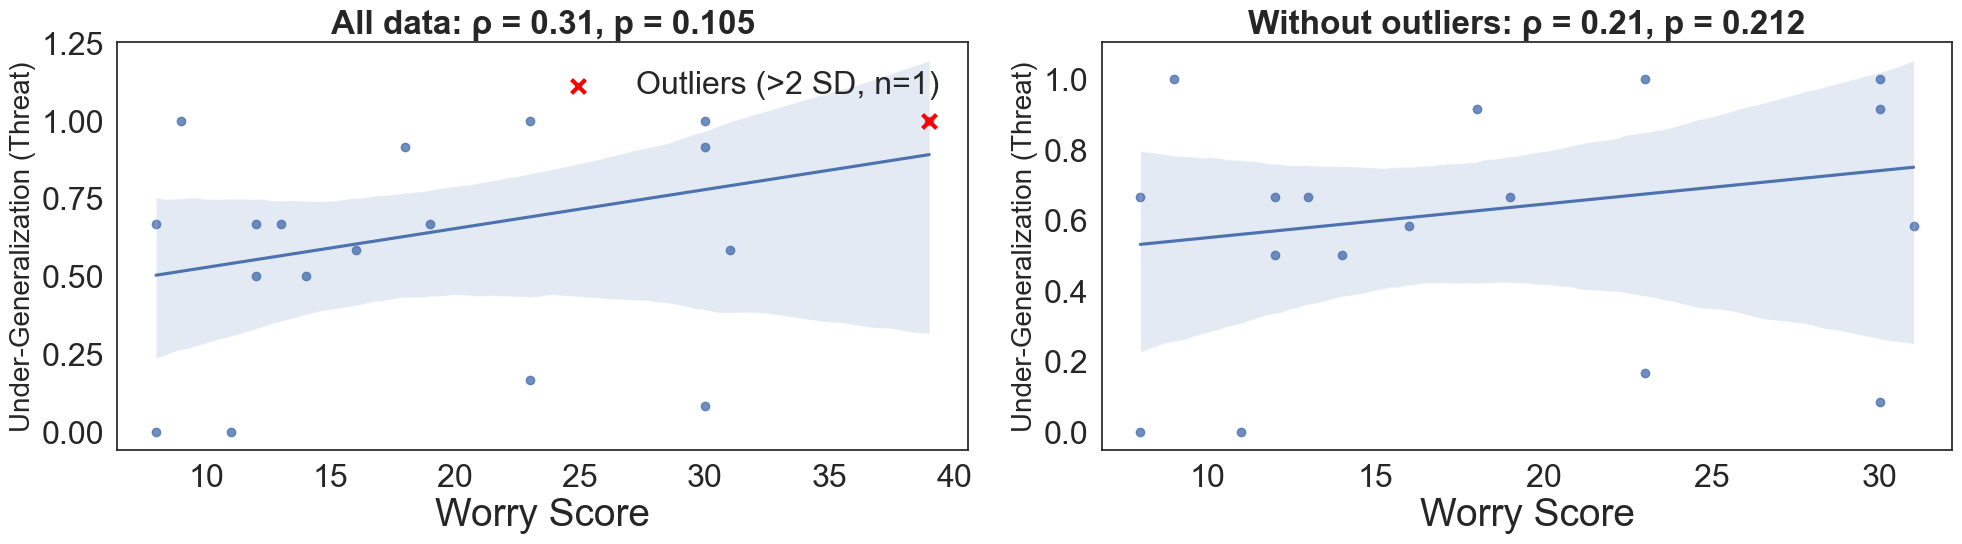

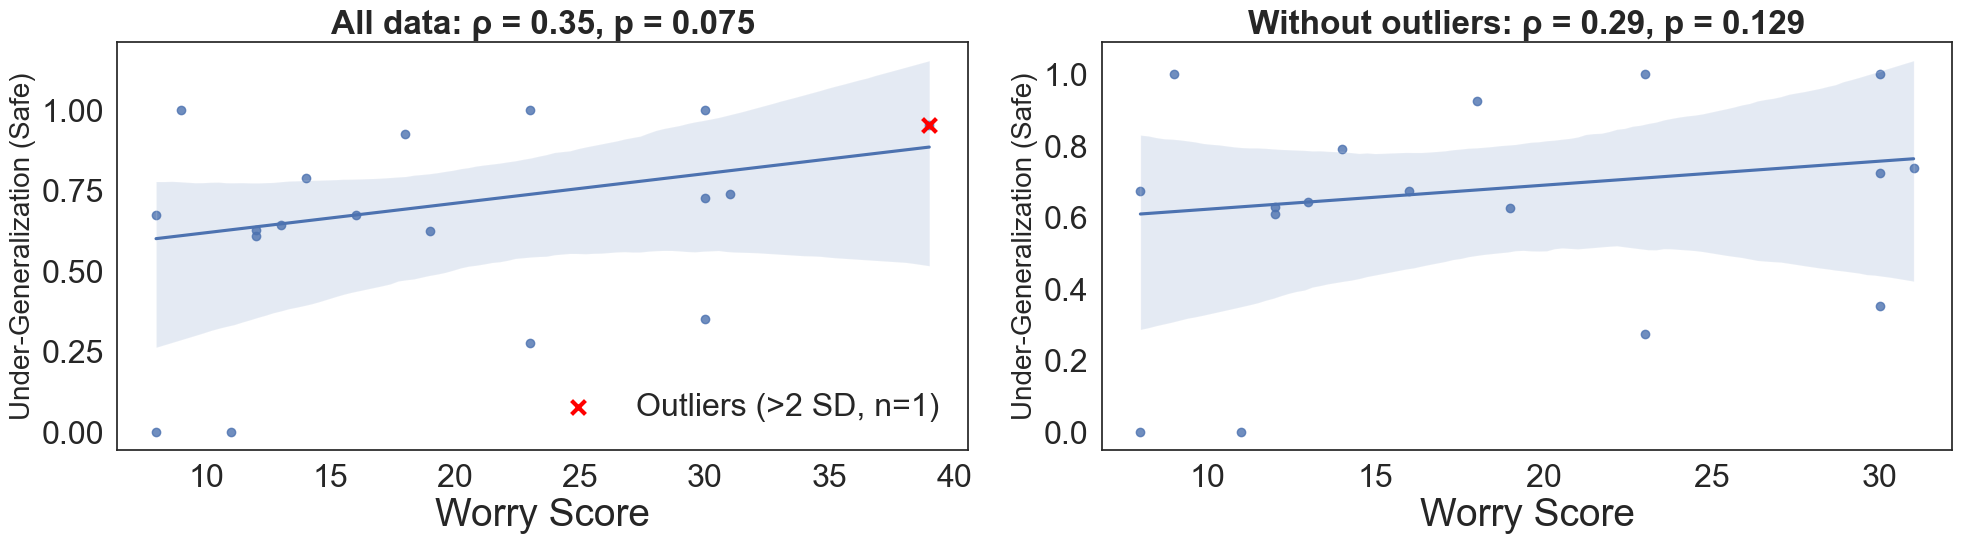

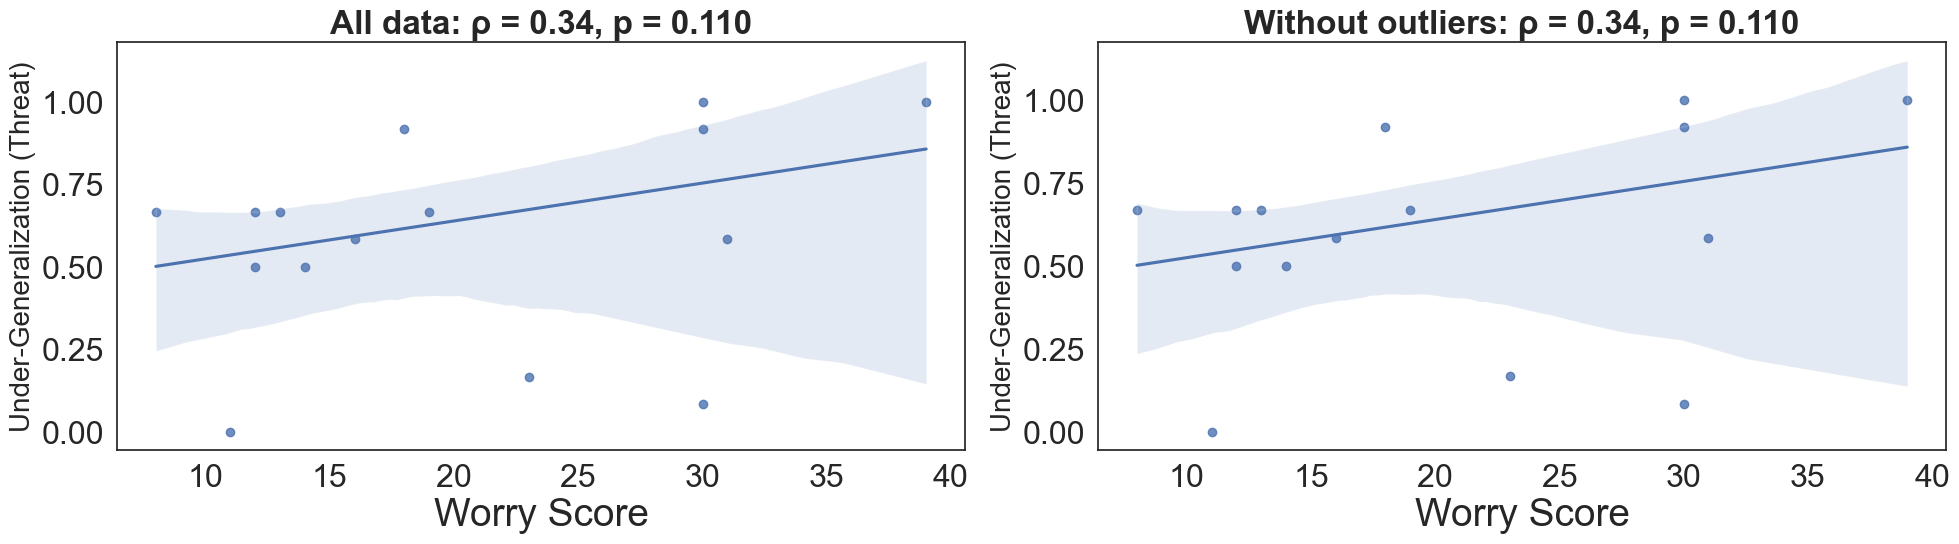

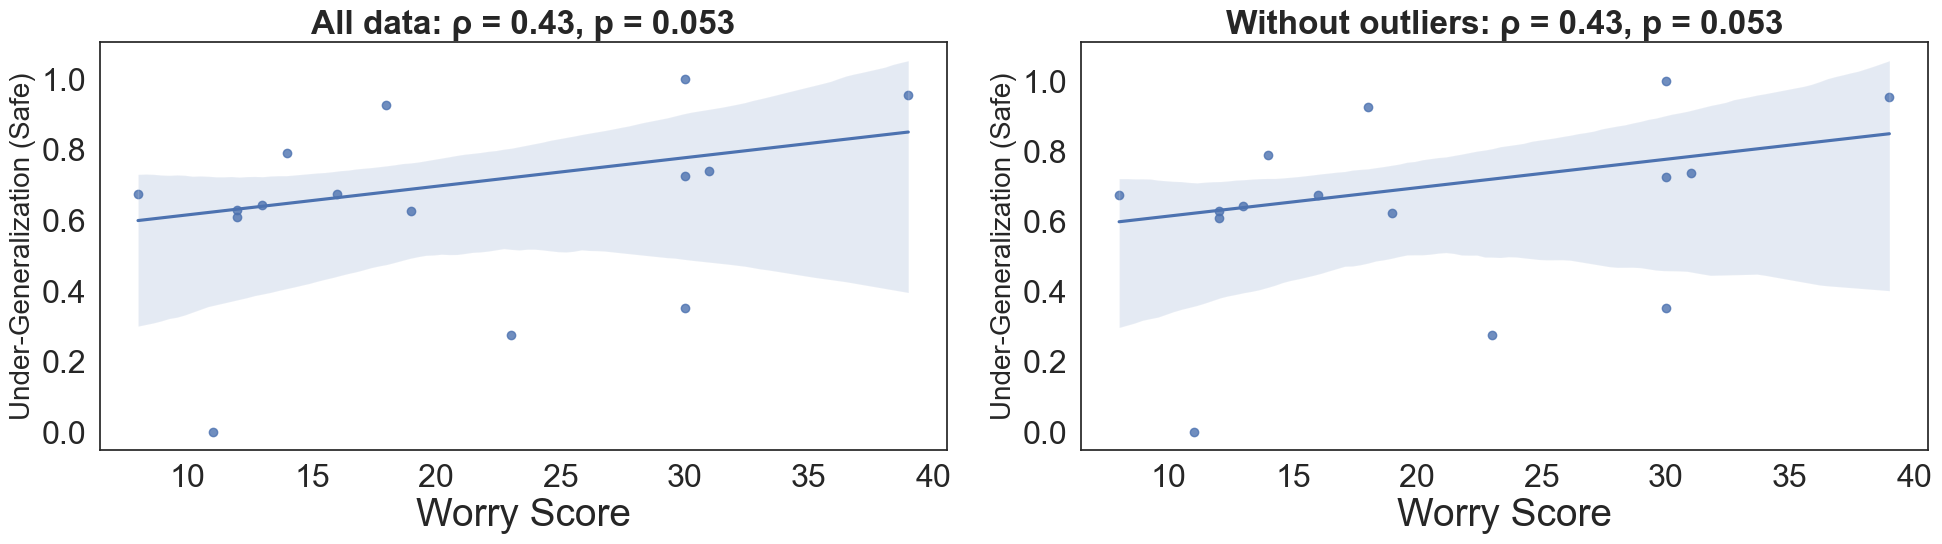

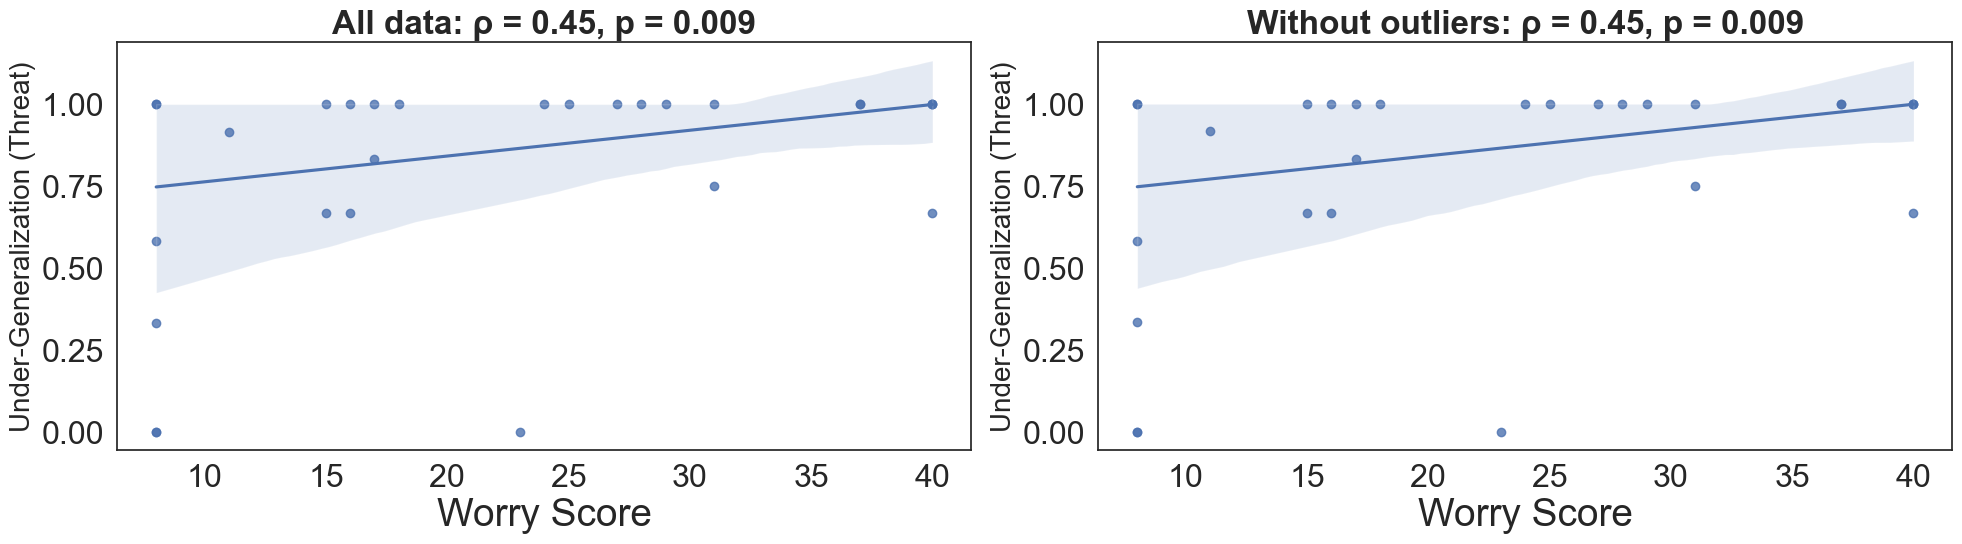

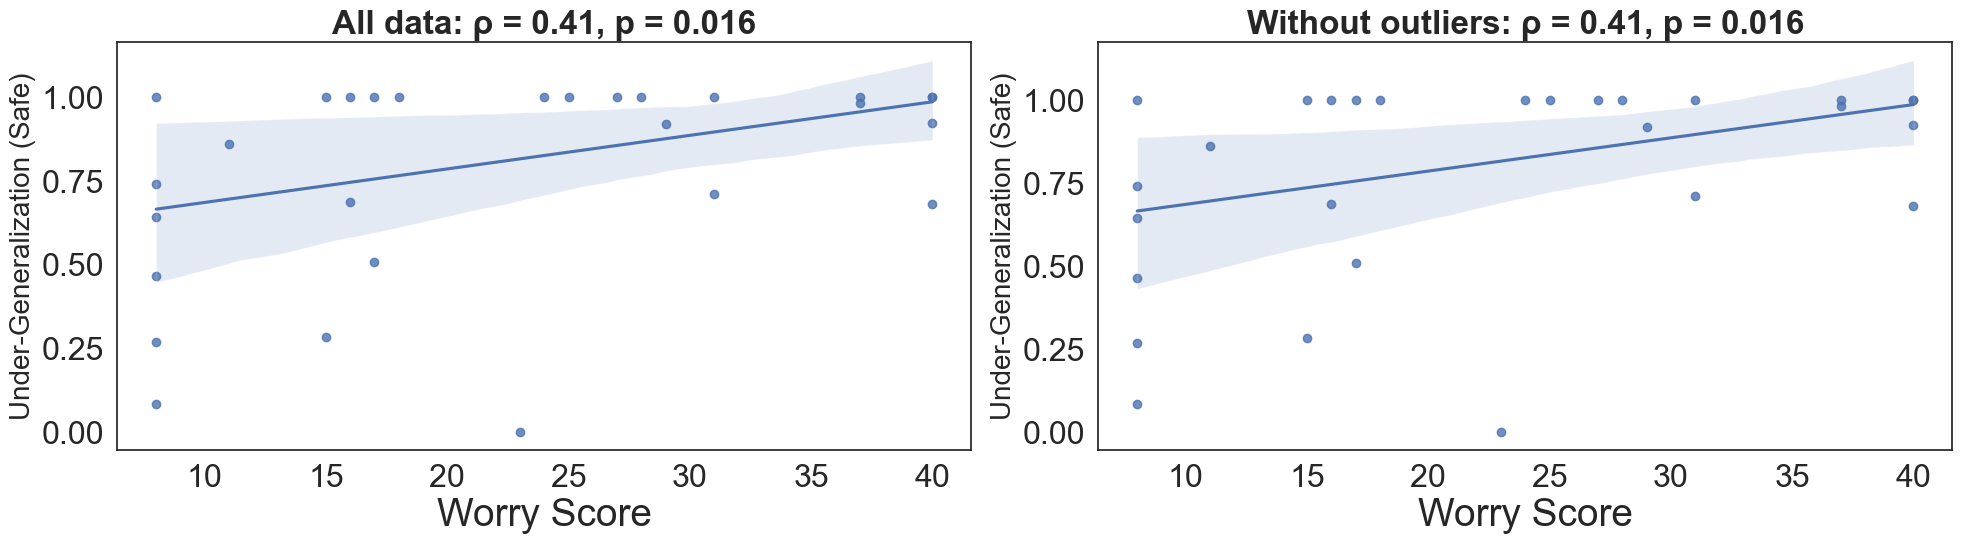

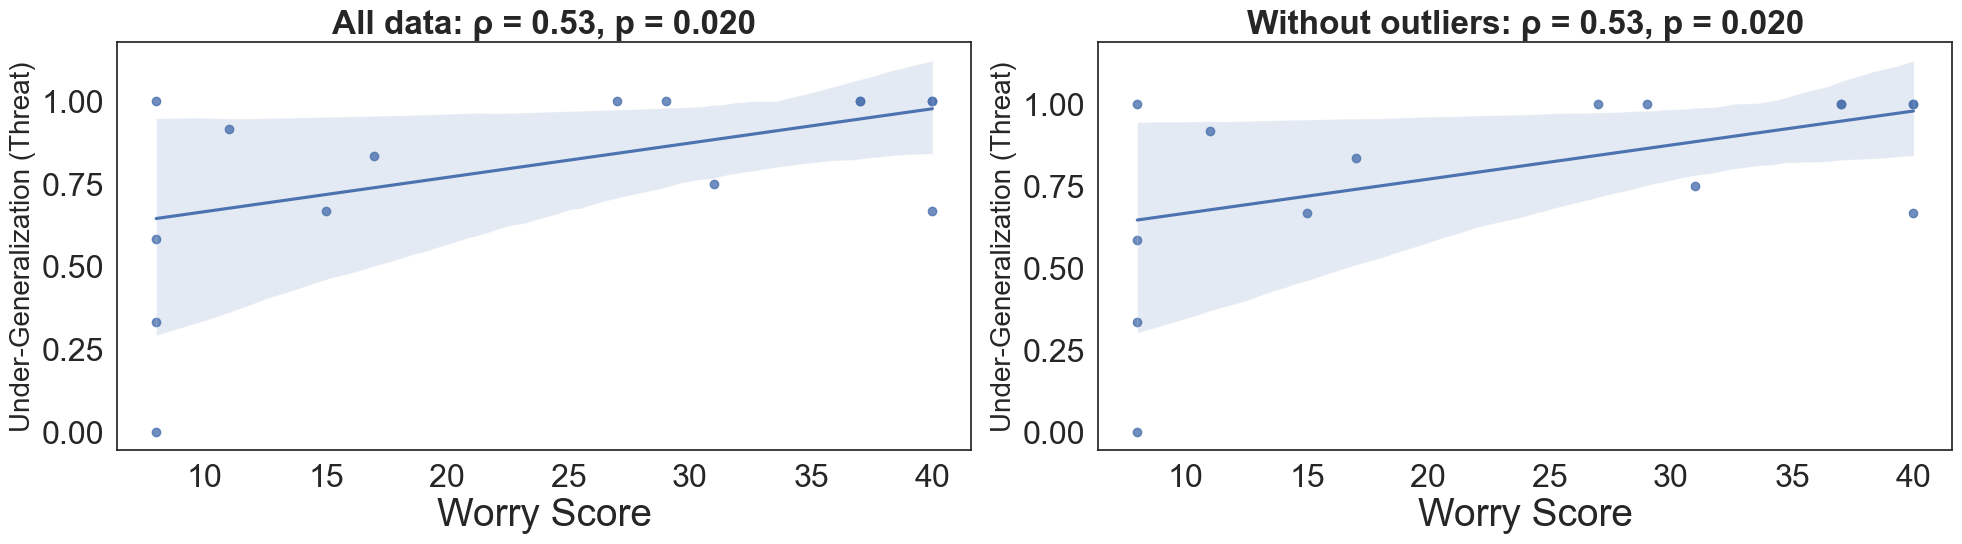

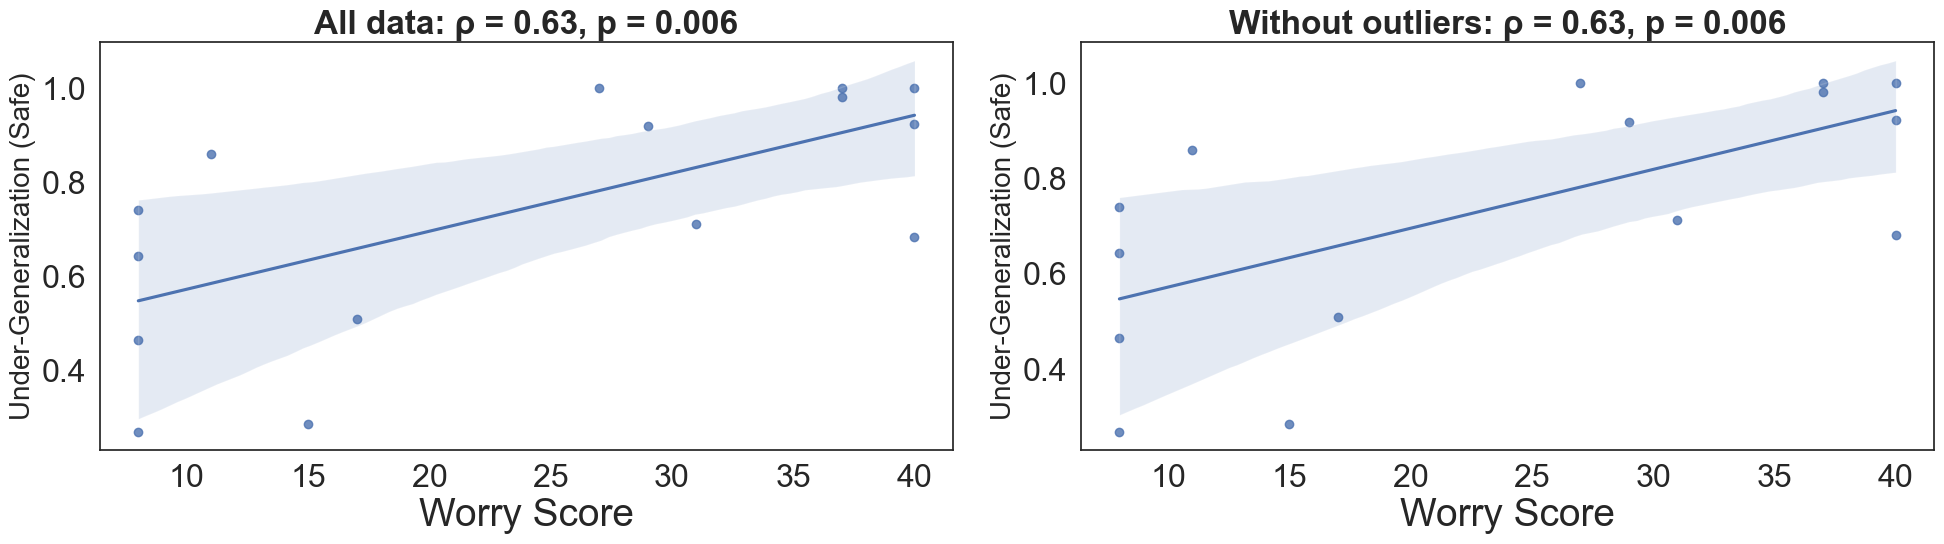

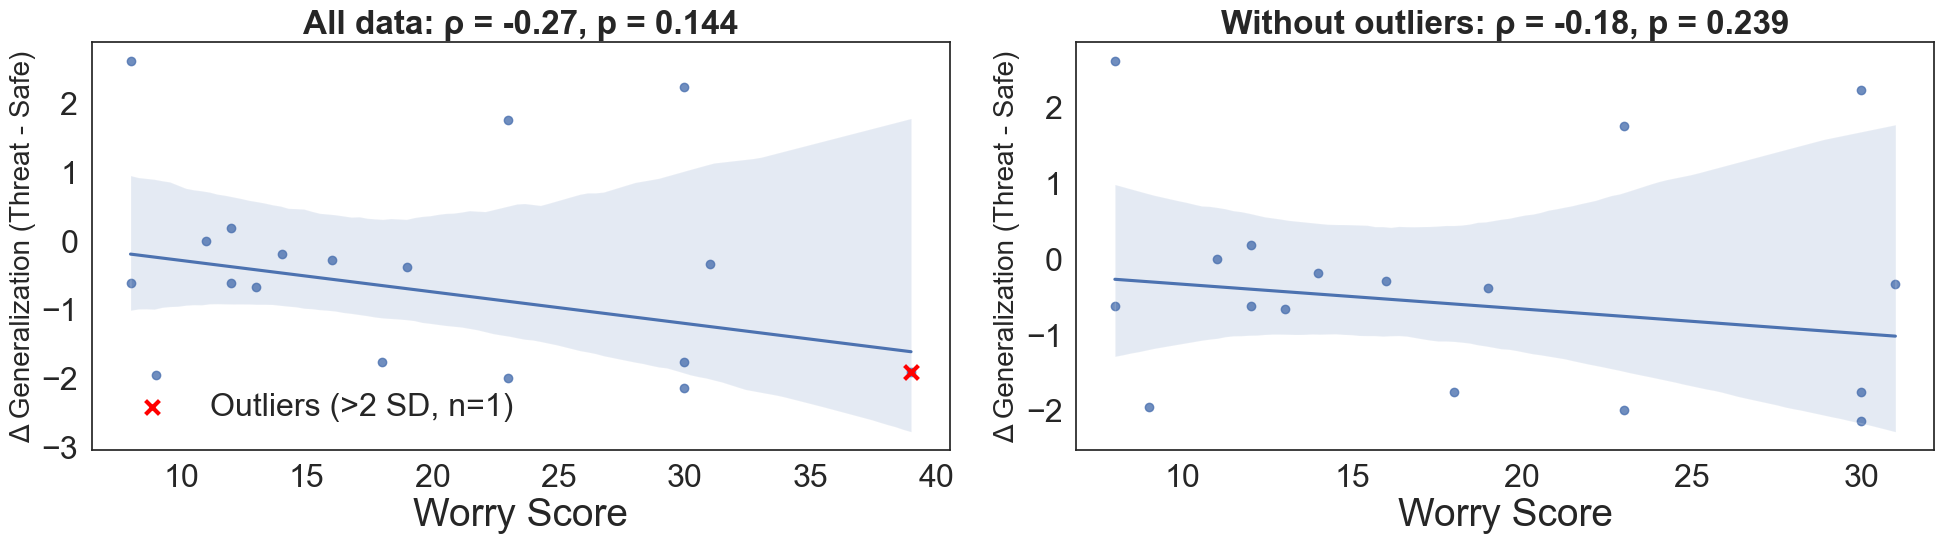

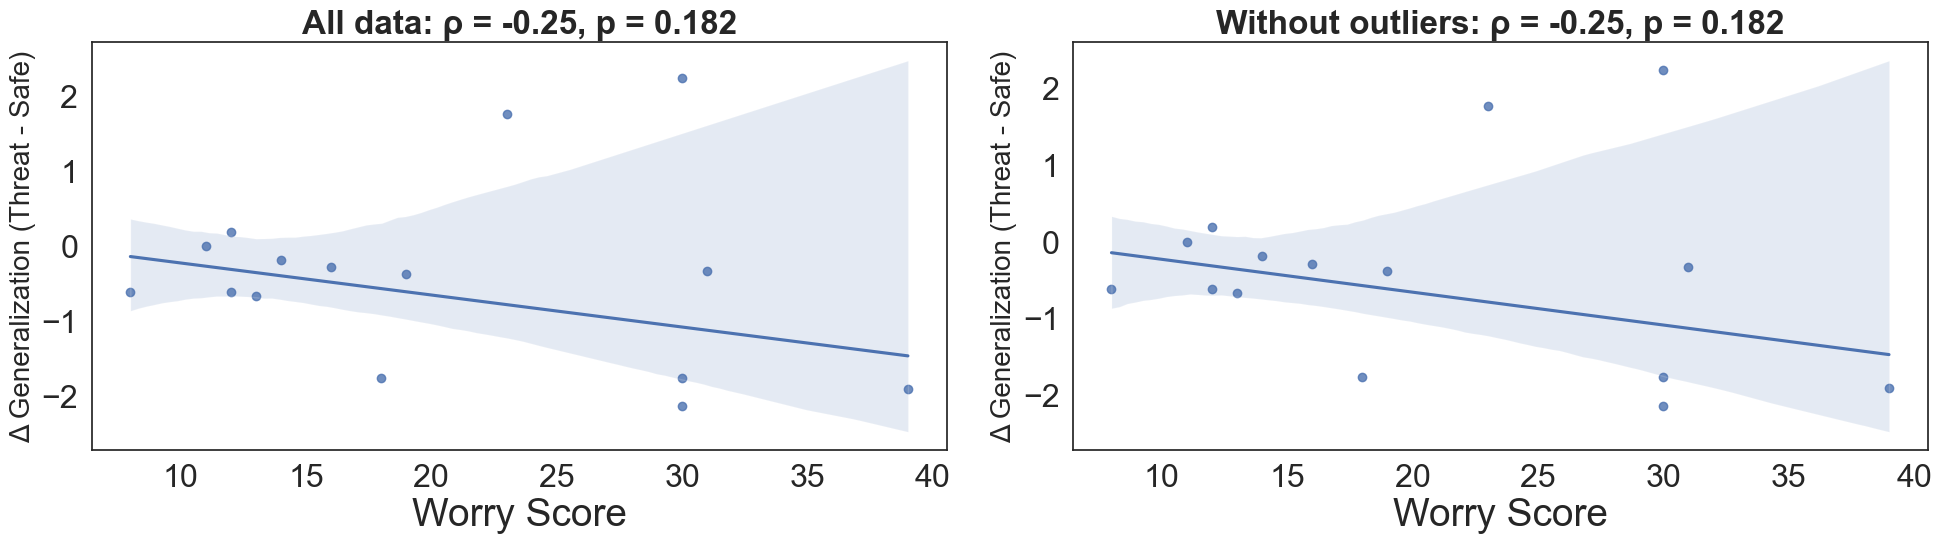

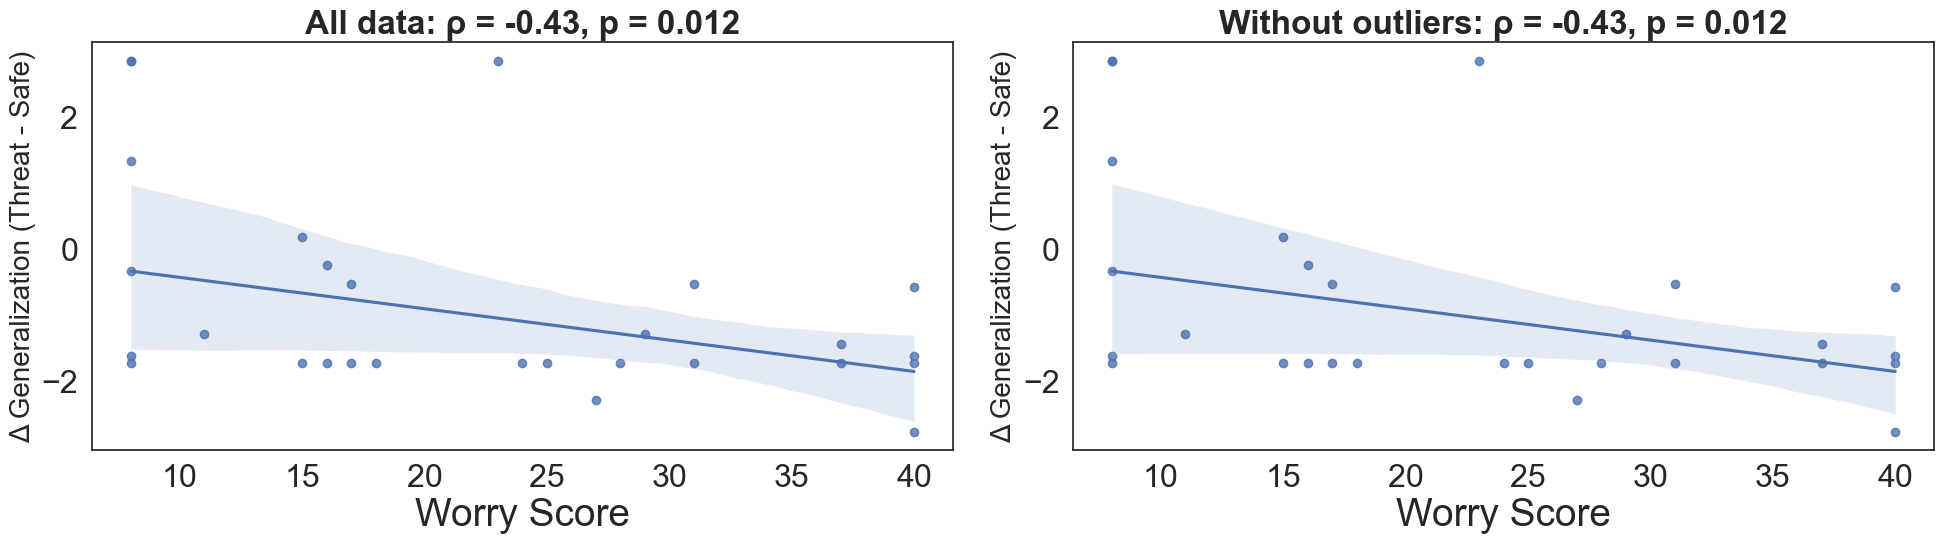

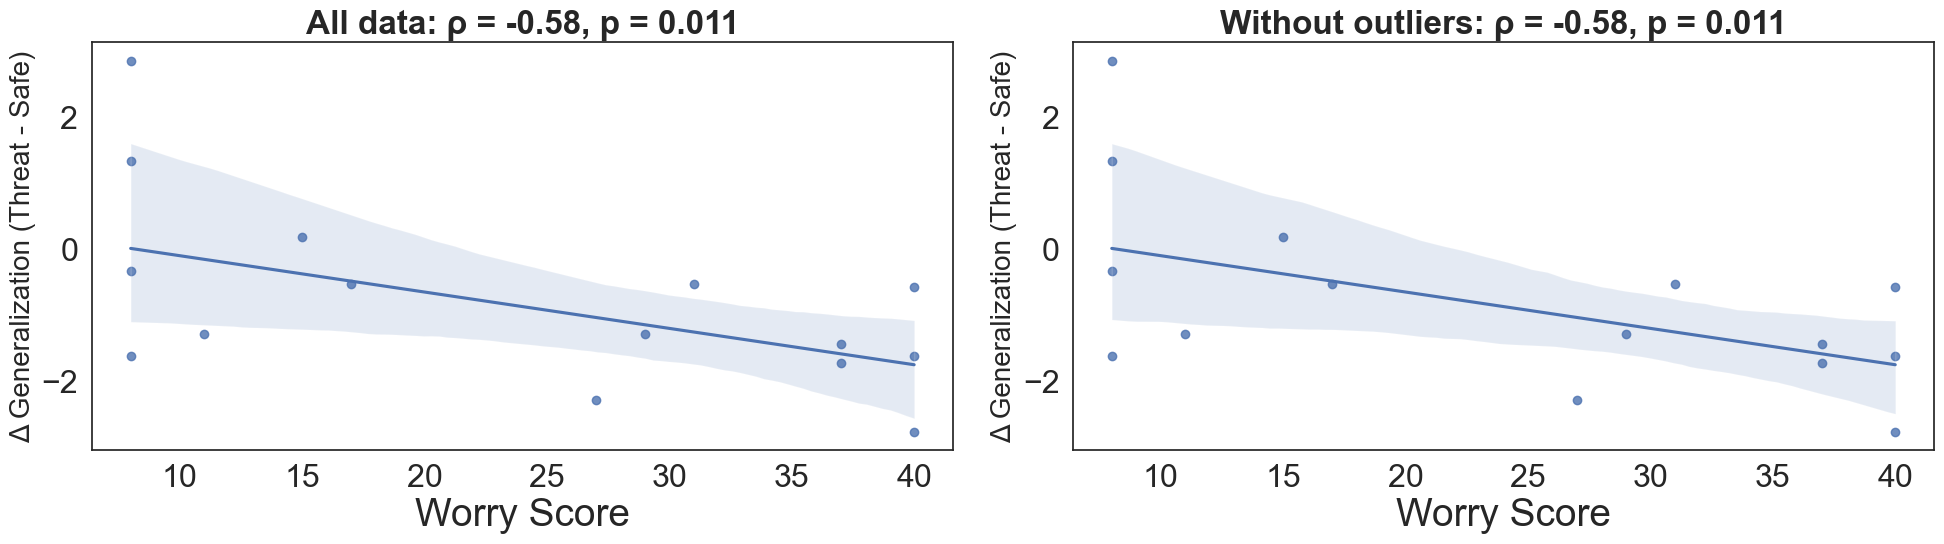

In [49]:
# Redo correlations without outliers
print("taking out outliers")
study1_all_df, study1_gen_df, study2_all_df, study2_gen_df = redo_correlations()

comment 1.3: regression with age and gender

In [7]:
def regression_analysis(study1_df, study2_df):
    """
    Run regressions: Under-generalization = B_0 + B_1*worry + B_2*age + B_3*Gender
    """
    print("\n" + "="*60)
    print("TASK 2: Regression Analysis with Age and Gender")
    print("="*60)

    for study_name, df in [("Study 1", study1_df), ("Study 2", study2_df)]:
        if df is None:
            continue

        print(f"\n{study_name} Regressions:")
        print("-" * 40)

        # Check if we have age and gender data
        if 'age' not in df.columns or 'gender' not in df.columns:
            print(f"  Warning: Age or gender data not available for {study_name}")
            continue

        # Prepare data

        # --- DIAGNOSTIC START: CHECK DATA LOSS ---
        target_cols = ['prop_toward', 'prop_toward_nd', WORRY_COL, 'age', 'gender']
        print(f"  [DEBUG] Starting N: {len(df)}")
        print(f"  [DEBUG] Missing values per column:\n{df[target_cols].isnull().sum()}")
        # -----------------------------------------


        reg_df = df[['prop_toward', 'prop_toward_nd', WORRY_COL, 'age', 'gender']].dropna()

        if len(reg_df) < 10:
            print(f"  Warning: Insufficient data for regression in {study_name} (n={len(reg_df)})")
            continue

        # Convert gender to numeric if it's categorical
        if reg_df['gender'].dtype == 'object':
            reg_df['gender_numeric'] = (reg_df['gender'].str.lower() == 'female').astype(int)
        else:
            reg_df['gender_numeric'] = reg_df['gender']

        # Regression for threat context (prop_toward)
        print(f"\n  Regression: prop_toward ~ worry + age + gender")
        try:
            X = sm.add_constant(reg_df[[WORRY_COL, 'age', 'gender_numeric']])
            y = reg_df['prop_toward']
            model = sm.OLS(y, X).fit()
            print(model.summary())
        except Exception as e:
            print(f"  Error in threat context regression: {e}")

        # Regression for safe context (prop_toward_nd)
        print(f"\n  Regression: prop_toward_nd ~ worry + age + gender")
        try:
            X = sm.add_constant(reg_df[[WORRY_COL, 'age', 'gender_numeric']])
            y = reg_df['prop_toward_nd']
            model = sm.OLS(y, X).fit()
            print(model.summary())
        except Exception as e:
            print(f"  Error in safe context regression: {e}")


In [17]:
# Regression analysis
print("running analysis by age and gender:")
# regression_analysis(study1_gen_df, study2_gen_df)
regression_analysis(study1_all_df, study2_all_df)

running analysis by age and gender:


NameError: name 'study1_all_df' is not defined

comment 1.5: bias analysis


BIAS ANALYSIS: STUDY 1
Split: 18 Generalizers, 3 Non-Generalizers

   [Confound Check] Study 1 (Generalizers Only)
      Median Worry: 20.0
      Contingency Table (Worry vs Small Car Threat):
is_small_car  False  True 
worry_group               
High              7      2
Low               7      2
      Chi2=0.000, p=1.0000
      OK: No significant relationship.

   [Higher-Order Bias] Generalizers
      N=18, Mean=-0.0132 ± 0.1293
      T-Test vs 0: t=-0.102, p=0.9196

   [Higher-Order Bias] Non-Generalizers
      N=3, Mean=1.0000 ± 0.0000
      T-Test vs 0: t=inf, p=0.0000

   [Lower-Order Regression] Generalizers
      N=1616 choices across 18 subjects
      Reference Category: big_car
      vs pickup_truck: Coef=-0.102, p=0.8372 
      vs small_car: Coef=1.564, p=0.0001 *
      vs truck: Coef=1.683, p=0.0001 *

BIAS ANALYSIS: STUDY 2
Split: 17 Generalizers, 13 Non-Generalizers

   [Confound Check] Study 2 (Generalizers Only)
      Median Worry: 20.0
      Contingency Table (Worr

/opt/miniconda3/envs/coding_basic/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Saved 'HigherOrderBias_Dynamic.png'
Saved 'LowerOrderPreferences_Dynamic.png'


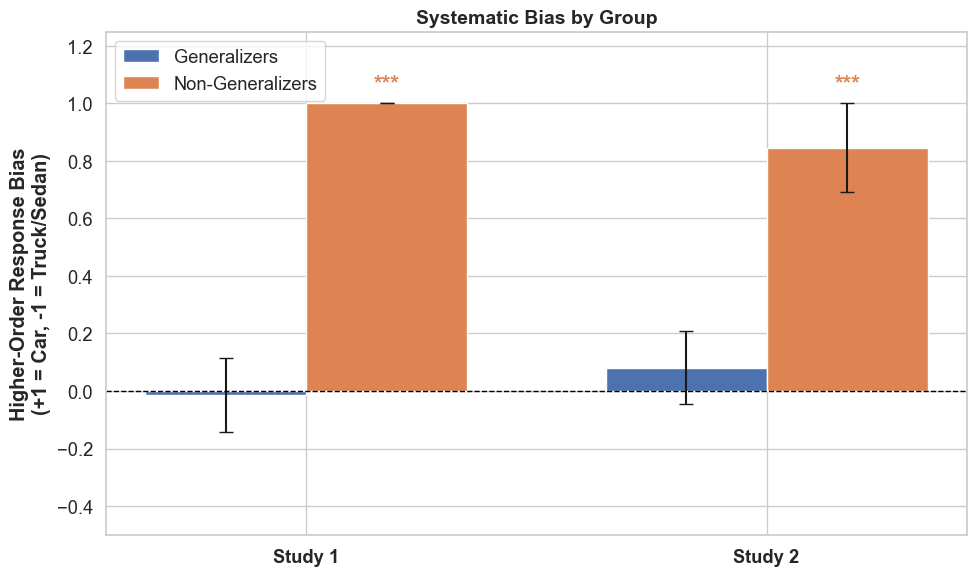

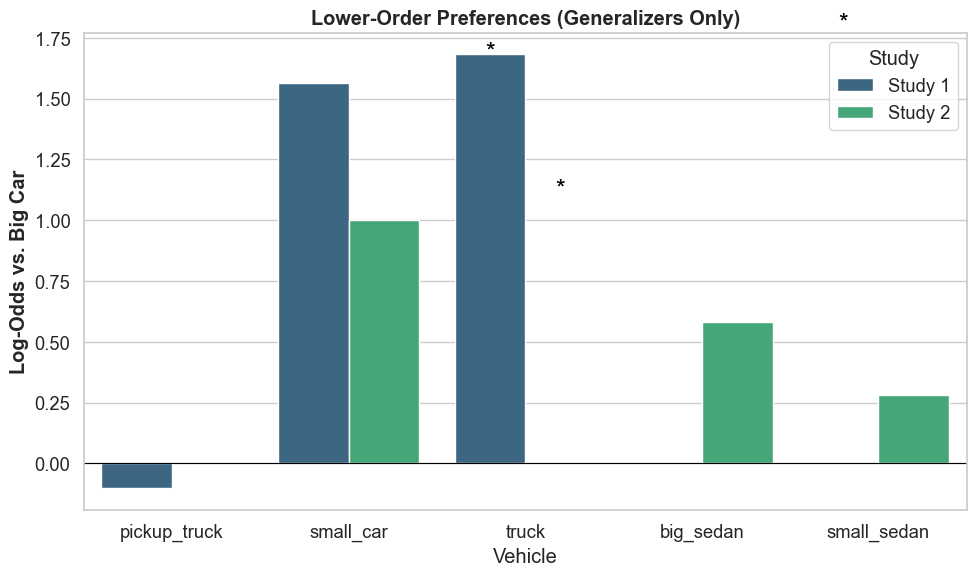

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from collections import defaultdict
from scipy.stats import chi2_contingency

# Set style
sns.set_theme(style="whitegrid", font_scale=1.2)

# File Paths
STUDY1_CSV = Path("game_trials_export_v1.csv")
STUDY2_CSV = Path("game_trials_export.csv")

# Columns
SUBJECT_COL = "prolificId"
PHASE_COL = "phase"
VEHICLE_COL = "vehicleType"
PLAN_COL = "plan_seq"
PARTICIPANT_ID_COL = "participant_id"
WORRY_COL = "worry"
THREAT_COL = "dangerous_vehicle"

# Key Mappings
STUDY1_VALID_KEYS = {
    "small_car": {"q", "w", "e", "c"}, "big_car": {"z", "x", "e", "c"},
    "truck": {"n", "m", "t", "b"}, "pickup_truck": {"y", "u", "t", "b"},
    "medium_car": {"q", "w", "z", "x", "e", "c"}, "dump_truck": {"n", "m", "y", "u", "t", "b"}
}
STUDY2_VALID_KEYS = {
    "small_car": {"a", "d", "w", "x"}, "big_car": {"s", "f", "e", "c"},
    "medium_car": {"a", "s", "d", "f", "w", "e", "x", "c"},
    "small_sedan": {"g", "j", "y", "n"}, "big_sedan": {"h", "k", "u", "m"},
    "medium_sedan": {"g", "h", "j", "k", "y", "u", "n", "m"}
}

# Analysis Settings
# Study 1: Car (+1) vs Truck (-1)
STUDY1_HO_MAP = {'small_car': 1, 'big_car': 1, 'medium_car': 1, 'truck': -1, 'pickup_truck': -1, 'dump_truck': -1}
STUDY1_LO_FILTER = ['small_car', 'big_car', 'truck', 'pickup_truck'] 

# Study 2: Car (+1) vs Sedan (-1)
STUDY2_HO_MAP = {'small_car': 1, 'big_car': 1, 'medium_car': 1, 'small_sedan': -1, 'big_sedan': -1, 'medium_sedan': -1}
STUDY2_LO_FILTER = ['small_car', 'big_car', 'small_sedan', 'big_sedan'] 


def parse_plan(seq):
    """Parses planning string into list of keys."""
    if not isinstance(seq, str): return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def identify_key_category(key, valid_keys, filter_list=None):
    """Finds which category a specific key belongs to."""
    possible_cats = []
    for cat, keys in valid_keys.items():
        if key in keys: possible_cats.append(cat)
    
    if filter_list:
        valid_cats = [c for c in possible_cats if c in filter_list]
        if valid_cats: return valid_cats[0]
    
    if possible_cats: return possible_cats[0]
    return None

def filter_subjects_by_key_coverage_simple(df, min_categories, valid_keys):
    """Splits IDs into Generalizers (>= min_categories) and Non-Generalizers."""
    key_to_categories = {}
    for cat, keys in valid_keys.items():
        for k in keys: key_to_categories.setdefault(k, set()).add(cat)
    
    gen_ids, nogen_ids = [], []
    for pid, grp in df.groupby(PARTICIPANT_ID_COL):
        keys_used = set()
        for seq in grp[PLAN_COL]: keys_used.update(parse_plan(seq))
        
        cats_covered = set()
        for k in keys_used: cats_covered.update(key_to_categories.get(k, []))
        
        if len(cats_covered) >= min_categories: gen_ids.append(pid)
        else: nogen_ids.append(pid)
    return gen_ids, nogen_ids

def check_confound(df, study_name):
    """
    Checks for relationship between Worry (High/Low) and 'Small Car' assignment.
    """
    print(f"\n   [Confound Check] {study_name}")
    
    # One row per subject
    df_subj = df.drop_duplicates(subset=[SUBJECT_COL]).copy()
    
    if df_subj.empty:
        print("      No subjects in this group.")
        return

    if WORRY_COL not in df_subj.columns or THREAT_COL not in df_subj.columns:
        print(f"      Missing '{WORRY_COL}' or '{THREAT_COL}'. Skipping check.")
        return

    # Median Split
    median_worry = df_subj[WORRY_COL].median()
    df_subj['worry_group'] = np.where(df_subj[WORRY_COL] > median_worry, 'High', 'Low')
    
    # Target Threat
    target = 'small_car'
    df_subj['is_small_car'] = df_subj[THREAT_COL] == target
    
    # Contingency Table
    tab = pd.crosstab(df_subj['worry_group'], df_subj['is_small_car'])
    print(f"      Median Worry: {median_worry}")
    print(f"      Contingency Table (Worry vs Small Car Threat):\n{tab}")
    
    # Chi-Square Test
    if tab.size >= 4:
        chi2, p, dof, ex = chi2_contingency(tab)
        print(f"      Chi2={chi2:.3f}, p={p:.4f}")
        if p < 0.05:
            print("      WARNING: Significant confound detected (Worry <-> Threat Assignment)!")
        else:
            print("      OK: No significant relationship.")
    else:
        print("      Insufficient data for Chi-Square.")

def compute_higher_order_bias(df, valid_keys, ho_mapping, study_name, group_name):
    """Computes HO Bias, Prints detailed stats, Returns dict for plotting."""
    print(f"\n   [Higher-Order Bias] {group_name}")
    
    subject_means = []
    for pid, group in df.groupby(PARTICIPANT_ID_COL):
        scores = []
        for _, row in group.iterrows():
            plan = parse_plan(row[PLAN_COL])
            for key in plan:
                cat = identify_key_category(key, valid_keys)
                if cat:
                    val = ho_mapping.get(cat, None)
                    if val is not None: scores.append(val)
        if scores: subject_means.append(np.mean(scores))
    
    if not subject_means:
        print("      No data.")
        return None

    grand_mean = np.mean(subject_means)
    se = np.std(subject_means, ddof=1) / np.sqrt(len(subject_means))
    
    # T-test
    if len(subject_means) > 1:
        t_stat, p_val = stats.ttest_1samp(subject_means, 0)
    else:
        # If N=1 or variance=0 (e.g. perfect bias), handle gracefully
        if se == 0:
             # Infinite t-stat if mean != 0
             t_stat = np.inf if grand_mean != 0 else 0
             p_val = 0.0 if grand_mean != 0 else 1.0
        else:
             t_stat, p_val = np.nan, np.nan

    print(f"      N={len(subject_means)}, Mean={grand_mean:.4f} ± {se:.4f}")
    print(f"      T-Test vs 0: t={t_stat:.3f}, p={p_val:.4f}")

    return {
        'Study': study_name,
        'Group': group_name,
        'N': len(subject_means),
        'Mean_Bias': grand_mean,
        'SE': se,
        'p_val': p_val
    }

def compute_lower_order_regression(df, valid_keys, filter_list, study_name, group_name):
    """Runs Multinomial Regression, Prints detailed stats, Returns list for plotting."""
    print(f"\n   [Lower-Order Regression] {group_name}")
    
    data_rows = []
    for pid, group in df.groupby(PARTICIPANT_ID_COL):
        for _, row in group.iterrows():
            plan = parse_plan(row[PLAN_COL])
            for key in plan:
                cat = identify_key_category(key, valid_keys, filter_list)
                if cat: data_rows.append({'sid': pid, 'choice': cat})

    long_df = pd.DataFrame(data_rows)
    if long_df.empty or long_df['choice'].nunique() < 2:
        print("      Insufficient data for regression.")
        return []

    # Prepare Regression
    long_df['choice'] = pd.Categorical(long_df['choice'])
    long_df['choice_code'] = long_df['choice'].cat.codes
    long_df['const'] = 1
    categories = long_df['choice'].cat.categories
    
    print(f"      N={len(long_df)} choices across {long_df['sid'].nunique()} subjects")
    print(f"      Reference Category: {categories[0]}")
    
    try:
        model = sm.MNLogit(long_df['choice_code'], long_df['const'])
        result = model.fit(cov_type='cluster', cov_kwds={'groups': long_df['sid']}, disp=0)
        
        plot_data = []
        for i, cat in enumerate(categories[1:], 1):
            coef = result.params.iloc[0, i-1]
            pval = result.pvalues.iloc[0, i-1]
            sig = "*" if pval < 0.05 else ""
            print(f"      vs {cat}: Coef={coef:.3f}, p={pval:.4f} {sig}")
            
            plot_data.append({
                'Study': study_name,
                'Vehicle': cat,
                'Coefficient': coef,
                'p_val': pval
            })
        return plot_data
    except Exception as e:
        print(f"      Regression Error: {e}")
        return []

def plot_higher_order_bias(results_list):
    if not results_list: return
    df = pd.DataFrame(results_list)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    studies = df['Study'].unique()
    x_pos = np.arange(len(studies))
    width = 0.35
    
    # Helper to safely extract values
    def get_vals(grp):
        sub = df[df['Group'] == grp]
        means, ses = [], []
        for s in studies:
            row = sub[sub['Study'] == s]
            if not row.empty:
                means.append(row['Mean_Bias'].iloc[0])
                ses.append(row['SE'].iloc[0])
            else:
                means.append(0); ses.append(0)
        return means, ses

    gen_m, gen_se = get_vals("Generalizers")
    nogen_m, nogen_se = get_vals("Non-Generalizers")

    ax.bar(x_pos - width/2, gen_m, width, yerr=gen_se, label='Generalizers', color='#4c72b0', capsize=5)
    ax.bar(x_pos + width/2, nogen_m, width, yerr=nogen_se, label='Non-Generalizers', color='#dd8452', capsize=5)

    ax.set_ylabel('Higher-Order Response Bias\n(+1 = Car, -1 = Truck/Sedan)', fontweight='bold')
    ax.set_title('Systematic Bias by Group', fontweight='bold', fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(studies, fontweight='bold')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(-0.5, 1.25)
    ax.legend()
    
    # Significance Stars
    for i, study in enumerate(studies):
        row = df[(df['Study'] == study) & (df['Group'] == "Non-Generalizers")]
        if not row.empty and row.iloc[0]['p_val'] < 0.001:
            ax.text(i + width/2, row.iloc[0]['Mean_Bias'] + row.iloc[0]['SE'] + 0.05, 
                    "***", ha='center', color='#dd8452', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig("HigherOrderBias_Dynamic.png", dpi=300)
    print("Saved 'HigherOrderBias_Dynamic.png'")

def plot_lower_order_regression(results_list):
    if not results_list: return
    df = pd.DataFrame(results_list)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=df, x="Vehicle", y="Coefficient", hue="Study", palette="viridis", ax=ax)
    
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylabel('Log-Odds vs. Big Car', fontweight='bold')
    ax.set_title('Lower-Order Preferences (Generalizers Only)', fontweight='bold')
    
    # Add stars
    unique_vehicles = sorted(df['Vehicle'].unique())
    n_studies = df['Study'].nunique()
    
    for i, row in df.iterrows():
        if row['p_val'] < 0.05:
            if row['Vehicle'] in unique_vehicles:
                x_idx = unique_vehicles.index(row['Vehicle'])
                # Adjust for hue offset
                offset = -0.2 if row['Study'] == "Study 1" else 0.2
                if n_studies == 1: offset = 0
                
                y_pos = row['Coefficient'] + (0.1 if row['Coefficient'] > 0 else -0.3)
                ax.text(x_idx + offset, y_pos, "*", ha='center', fontsize=18, color='black')

    plt.tight_layout()
    plt.savefig("LowerOrderPreferences_Dynamic.png", dpi=300)
    print("Saved 'LowerOrderPreferences_Dynamic.png'")

def run_full_analysis():
    ho_results = []
    lo_results = []

    # PROCESS STUDY 1
    if STUDY1_CSV.exists():
        print(f"\n{'='*60}\nBIAS ANALYSIS: STUDY 1\n{'='*60}")
        df1 = pd.read_csv(STUDY1_CSV)
        df1 = df1[df1[PHASE_COL] == 2].copy()
        
        u_ids = df1[SUBJECT_COL].unique()
        id_map = {uid: i for i, uid in enumerate(u_ids)}
        df1[PARTICIPANT_ID_COL] = df1[SUBJECT_COL].map(id_map)
        
        # Split Groups
        gen, nogen = filter_subjects_by_key_coverage_simple(df1, 4, STUDY1_VALID_KEYS)
        print(f"Split: {len(gen)} Generalizers, {len(nogen)} Non-Generalizers")
        
        # --- MODIFIED: Confound Check for Generalizers Only ---
        df1_gen = df1[df1[PARTICIPANT_ID_COL].isin(gen)].copy()
        check_confound(df1_gen, "Study 1 (Generalizers Only)")
        # ----------------------------------------------------
        
        # Higher-Order Bias
        ho_results.append(compute_higher_order_bias(df1[df1[PARTICIPANT_ID_COL].isin(gen)], 
                                                    STUDY1_VALID_KEYS, STUDY1_HO_MAP, "Study 1", "Generalizers"))
        ho_results.append(compute_higher_order_bias(df1[df1[PARTICIPANT_ID_COL].isin(nogen)], 
                                                    STUDY1_VALID_KEYS, STUDY1_HO_MAP, "Study 1", "Non-Generalizers"))
        
        # Lower-Order Regression (Generalizers Only)
        lo_results.extend(compute_lower_order_regression(df1[df1[PARTICIPANT_ID_COL].isin(gen)], 
                                                         STUDY1_VALID_KEYS, STUDY1_LO_FILTER, "Study 1", "Generalizers"))

    # PROCESS STUDY 2
    if STUDY2_CSV.exists():
        print(f"\n{'='*60}\nBIAS ANALYSIS: STUDY 2\n{'='*60}")
        df2 = pd.read_csv(STUDY2_CSV)
        df2 = df2[df2[PHASE_COL] == 2].copy()
        
        u_ids = df2[SUBJECT_COL].unique()
        id_map = {uid: i for i, uid in enumerate(u_ids)}
        df2[PARTICIPANT_ID_COL] = df2[SUBJECT_COL].map(id_map)
        
        # Split Groups
        gen, nogen = filter_subjects_by_key_coverage_simple(df2, 4, STUDY2_VALID_KEYS)
        print(f"Split: {len(gen)} Generalizers, {len(nogen)} Non-Generalizers")

        # --- MODIFIED: Confound Check for Generalizers Only ---
        df2_gen = df2[df2[PARTICIPANT_ID_COL].isin(gen)].copy()
        check_confound(df2_gen, "Study 2 (Generalizers Only)")
        # ----------------------------------------------------

        # 1. Higher-Order Bias
        ho_results.append(compute_higher_order_bias(df2[df2[PARTICIPANT_ID_COL].isin(gen)], 
                                                    STUDY2_VALID_KEYS, STUDY2_HO_MAP, "Study 2", "Generalizers"))
        ho_results.append(compute_higher_order_bias(df2[df2[PARTICIPANT_ID_COL].isin(nogen)], 
                                                    STUDY2_VALID_KEYS, STUDY2_HO_MAP, "Study 2", "Non-Generalizers"))
        
        # 2. Lower-Order Regression (Generalizers Only)
        lo_results.extend(compute_lower_order_regression(df2[df2[PARTICIPANT_ID_COL].isin(gen)], 
                                                         STUDY2_VALID_KEYS, STUDY2_LO_FILTER, "Study 2", "Generalizers"))

    # Plot
    print("\n" + "-"*30)
    print("Generating Plots...")
    ho_results = [r for r in ho_results if r is not None]
    plot_higher_order_bias(ho_results)
    plot_lower_order_regression(lo_results)

# Run It
if __name__ == "__main__":
    run_full_analysis()

In [66]:
import pandas as pd
from scipy.stats import chisquare
from pathlib import Path

# CONFIG
STUDY1_CSV = Path("game_trials_export_v1.csv")
STUDY2_CSV = Path("game_trials_export.csv")
SUBJECT_COL = "prolificId"
DANGEROUS_COL = "dangerous_vehicle"

def get_cat(v_name):
    v_name = str(v_name).lower()
    if "small" in v_name and "car" in v_name: return "small_car"
    if "big" in v_name and "car" in v_name: return "big_car"
    if "truck" in v_name and "pickup" not in v_name and "dump" not in v_name: return "truck"
    if "pickup" in v_name: return "pickup_truck"
    if "small" in v_name and "sedan" in v_name: return "small_sedan"
    if "big" in v_name and "sedan" in v_name: return "big_sedan"
    return "other"

def check_random(csv_path, name):
    if not csv_path.exists(): return
    df = pd.read_csv(csv_path)
    # Get unique subject assignments
    data = df.groupby(SUBJECT_COL)[DANGEROUS_COL].first().reset_index()
    data['cat'] = data[DANGEROUS_COL].apply(get_cat)
    
    # Filter for valid categories only
    counts = data['cat'].value_counts()
    print(f"\n--- {name} Threat Counts ---")
    print(counts)
    
    # Chi-Square Test
    chi2, p = chisquare(counts)
    print(f"Chi-Square: {chi2:.2f}, p = {p:.3f}")

check_random(STUDY1_CSV, "Study 1")
check_random(STUDY2_CSV, "Study 2")


--- Study 1 Threat Counts ---
cat
pickup_truck    7
small_car       5
truck           5
big_car         4
Name: count, dtype: int64
Chi-Square: 0.90, p = 0.824

--- Study 2 Threat Counts ---
cat
small_car      12
small_sedan     8
big_car         7
big_sedan       3
Name: count, dtype: int64
Chi-Square: 5.47, p = 0.141


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import chi2_contingency
import numpy as np

def category_bias_analysis(csv_path, valid_keys, study_name, 
                           worry_col='PSWQ', 
                           threat_col='threat_category', 
                           subject_col='subject_id'):
    """
    1. Checks for assignment bias (Worry levels vs. Small Car assignment).
    2. Creates bar plot of keys per category to look for systematic biases.
    """
    print(f"\n{'='*60}")
    print(f"TASK 3: Category Bias & Confound Analysis - {study_name}")
    print(f"{'='*60}\n")

    if not csv_path.exists():
        print(f"Error: Data file not found at '{csv_path}'")
        return

    df = pd.read_csv(csv_path)

    # ---------------------------------------------------------
    # PART 1: Confound Check (Worry vs. Threat Assignment)
    # ---------------------------------------------------------
    print(f"--- Confound Analysis: High Worry vs. 'Small Car' Assignment ---")
    
    # Drop duplicates to get one row per subject for demographic analysis
    df_subjects = df.drop_duplicates(subset=[subject_col]).copy()
    
    if worry_col not in df_subjects.columns or threat_col not in df_subjects.columns:
        print(f"⚠️  Skipping confound check: '{worry_col}' or '{threat_col}' columns missing.")
    else:
        # 1. Median Split Worry
        median_worry = df_subjects[worry_col].median()
        df_subjects['worry_group'] = np.where(df_subjects[worry_col] > median_worry, 'High Worry', 'Low Worry')
        
        # 2. Identify if assigned threat was 'Small Car' (adjust string if needed)
        # We assume the threat_col contains strings like 'Small Car', 'SUV', etc.
        target_threat = 'Small Car'
        df_subjects['is_small_car_threat'] = df_subjects[threat_col] == target_threat

        # 3. Create Contingency Table
        contingency_table = pd.crosstab(df_subjects['worry_group'], df_subjects['is_small_car_threat'])
        
        print(f"\nMedian Worry Score: {median_worry}")
        print("\nAssignment Counts (Subject N):")
        print(contingency_table)

        # 4. Chi-Square Test
        # We check if 'is_small_car_threat' is independent of 'worry_group'
        if contingency_table.size >= 4:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"\nChi-Square Test results:")
            print(f"Chi2 stat: {chi2:.4f}, p-value: {p:.4f}")
            
            if p < 0.05:
                print("❌ WARNING: Significant relationship found between Worry and Condition assignment.")
            else:
                print("✅ PASSED: No significant relationship between Worry and Condition assignment.")
        else:
            print("⚠️  Not enough data categories for Chi-Square test.")
            
    print("-" * 60)

    # ---------------------------------------------------------
    # PART 2: Key Press Analysis
    # ---------------------------------------------------------
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    # Count key presses by category
    category_counts = defaultdict(int)

    for _, row in df_phase2.iterrows():
        vehicle = row[VEHICLE_COL]
        # Ensure 'parse_plan' is defined in your scope
        plan = parse_plan(row[PLAN_COL]) 

        for key in plan:
            # Check which categories this key belongs to
            for category, keys in valid_keys.items():
                if key in keys:
                    category_counts[category] += 1

    # Create dataframe for plotting
    plot_df = pd.DataFrame([
        {'Category': cat, 'Count': count}
        for cat, count in category_counts.items()
    ])
    plot_df = plot_df.sort_values('Count', ascending=False)

    # Create plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=plot_df, x='Category', y='Count', palette='viridis')
    plt.title(f'{study_name}: Key Press Frequency by Category', fontsize=16, weight='bold')
    plt.xlabel('Vehicle Category', fontsize=14)
    plt.ylabel('Total Key Presses', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    filename = f'{study_name.lower().replace(" ", "_")}_category_key_frequency.png'
    plt.savefig(filename, dpi=300)
    print(f"\n✅ Bar plot saved to '{filename}'")

    # Print summary statistics
    print(f"\n{study_name} Category Statistics:")
    print(plot_df.to_string(index=False))

    # Calculate some bias metrics
    total_presses = plot_df['Count'].sum()
    if total_presses > 0:
        plot_df['Percentage'] = (plot_df['Count'] / total_presses * 100).round(2)
        print(f"\nPercentage distribution:")
        print(plot_df[['Category', 'Percentage']].to_string(index=False))

In [16]:
# Category bias analysis
category_bias_analysis(STUDY1_CSV, STUDY1_VALID_KEYS, "Study 1")
category_bias_analysis(STUDY2_CSV, STUDY2_VALID_KEYS, "Study 2")


TASK 3: Category Bias & Confound Analysis - Study 1

--- Confound Analysis: High Worry vs. 'Small Car' Assignment ---


KeyError: Index(['subject_id'], dtype='object')

In [12]:
def error_bias_analysis(csv_path, valid_keys, study_name):
    """
    Create bar plot of ERROR keys per category to look for systematic biases.
    Counts only keys that were INCORRECT for the specific trial.
    """
    print(f"\n{'='*60}")
    print(f"TASK 3: Error Bias Analysis (Mistakes Only) - {study_name}")
    print(f"{'='*60}\n")

    if not csv_path.exists():
        print(f"Error: Data file not found at '{csv_path}'")
        return

    df = pd.read_csv(csv_path)
    # Filter for Phase 2 (Planning Phase)
    df_phase2 = df[df[PHASE_COL] == 2].copy()

    # Count ERROR key presses attributed to each category
    error_category_counts = defaultdict(int)
    total_mistaken_keys = 0

    for _, row in df_phase2.iterrows():
        vehicle = row[VEHICLE_COL]
        plan = parse_plan(row[PLAN_COL])
        
        # Identify the valid keys for the CURRENT target vehicle
        # (These are NOT mistakes)
        target_keys = set(valid_keys.get(vehicle, []))

        for key in plan:
            # OPTION 1: Strict Error Definition
            # Only analyze the key if it does NOT belong to the current vehicle
            if key not in target_keys:
                total_mistaken_keys += 1
                
                # Check which OTHER categories this incorrect key belongs to
                found_match = False
                for category, cat_keys in valid_keys.items():
                    # Skip the target category (we already know it's not there)
                    if category == vehicle:
                        continue
                    
                    if key in cat_keys:
                        error_category_counts[category] += 1
                        found_match = True

    # Create dataframe for plotting
    plot_df = pd.DataFrame([
        {'Category': cat, 'Error_Count': count}
        for cat, count in error_category_counts.items()
    ])
    
    if plot_df.empty:
        print("No errors found or insufficient data to plot.")
        return

    plot_df = plot_df.sort_values('Error_Count', ascending=False)

    # Create plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=plot_df, x='Category', y='Error_Count', palette='magma') # Changed palette to distinguish from previous plot
    plt.title(f'{study_name}: Frequency of Generalization Errors by Category', fontsize=16, weight='bold')
    plt.xlabel('Category Attributed to Error', fontsize=14)
    plt.ylabel('Count of Incorrect Key Presses', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    filename = f'{study_name.lower().replace(" ", "_")}_error_bias_frequency.png'
    plt.savefig(filename, dpi=300)
    print(f"✅ Error Bias plot saved to '{filename}'")

    # Print summary statistics
    print(f"\n{study_name} Error Bias Statistics:")
    print(f"Total Mistaken Key Presses Analyzed: {total_mistaken_keys}")
    print(plot_df.to_string(index=False))

    # Calculate percentage
    total_errors_attributed = plot_df['Error_Count'].sum()
    if total_errors_attributed > 0:
        plot_df['Percentage'] = (plot_df['Error_Count'] / total_errors_attributed * 100).round(2)
        print(f"\nPercentage distribution of errors:")
        print(plot_df[['Category', 'Percentage']].to_string(index=False))


TASK 3: Error Bias Analysis (Mistakes Only) - Study 1



/var/folders/db/mkhd3ldd611d0ncwt82ndwmr0000gn/T/ipykernel_42033/3734547789.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Category', y='Error_Count', palette='magma') # Changed palette to distinguish from previous plot


✅ Error Bias plot saved to 'study_1_error_bias_frequency.png'

Study 1 Error Bias Statistics:
Total Mistaken Key Presses Analyzed: 1107
    Category  Error_Count
  medium_car          564
   small_car          490
  dump_truck          431
       truck          368
     big_car          310
pickup_truck          293

Percentage distribution of errors:
    Category  Percentage
  medium_car       22.96
   small_car       19.95
  dump_truck       17.55
       truck       14.98
     big_car       12.62
pickup_truck       11.93

TASK 3: Error Bias Analysis (Mistakes Only) - Study 2



/var/folders/db/mkhd3ldd611d0ncwt82ndwmr0000gn/T/ipykernel_42033/3734547789.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Category', y='Error_Count', palette='magma') # Changed palette to distinguish from previous plot


✅ Error Bias plot saved to 'study_2_error_bias_frequency.png'

Study 2 Error Bias Statistics:
Total Mistaken Key Presses Analyzed: 1799
    Category  Error_Count
  medium_car         1203
   small_car          969
medium_sedan          487
   big_sedan          294
     big_car          234
 small_sedan          193

Percentage distribution of errors:
    Category  Percentage
  medium_car       35.59
   small_car       28.67
medium_sedan       14.41
   big_sedan        8.70
     big_car        6.92
 small_sedan        5.71


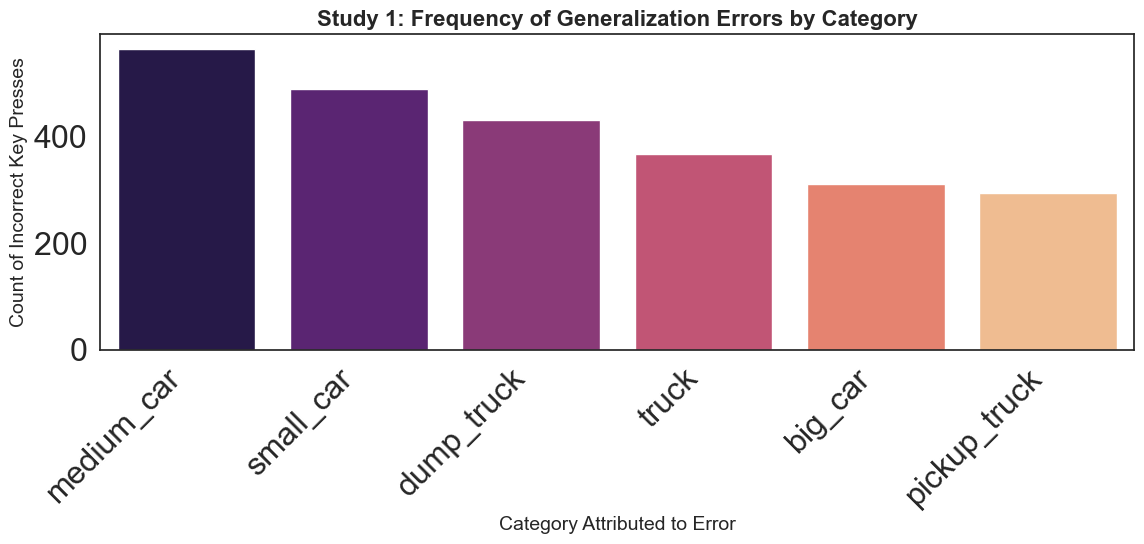

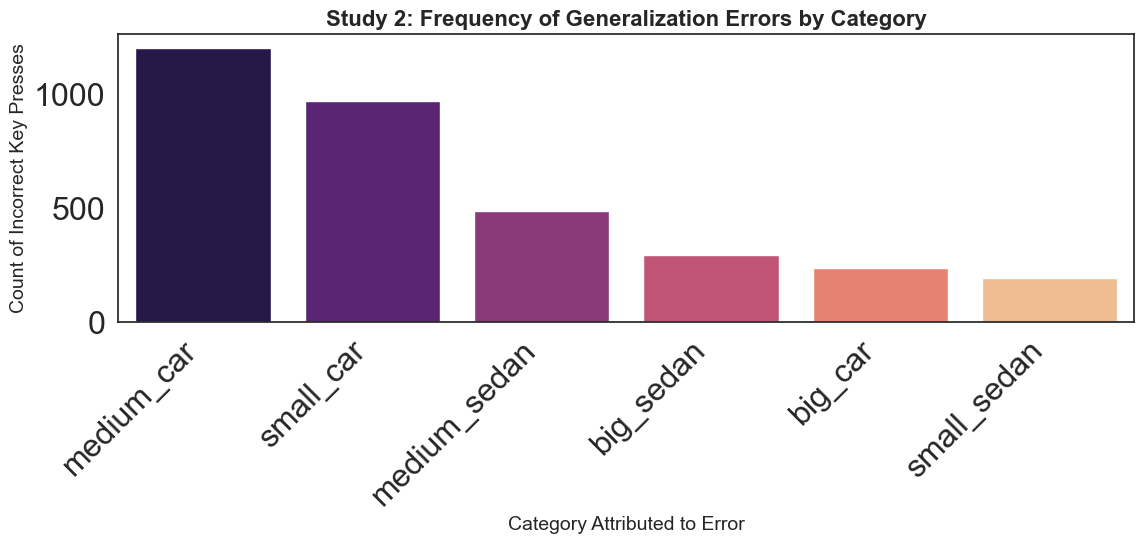

In [13]:
error_bias_analysis(STUDY1_CSV, STUDY1_VALID_KEYS, "Study 1")
error_bias_analysis(STUDY2_CSV, STUDY2_VALID_KEYS, "Study 2")

Comment 2.4: active avoidence

Loading participant summary...

RESULTS: Active Avoidance (Threat Usage)
High Worry (N=15): 11.05% ± 6.73% (SE)
Low Worry  (N=15): 31.74% ± 7.93% (SE)
------------------------------
High vs Chance (25%): t=-2.074, p=0.0570
Low vs Chance (25%):  t=0.850, p=0.4096
High vs Low Difference: t=-1.990, p=0.0565


/var/folders/db/mkhd3ldd611d0ncwt82ndwmr0000gn/T/ipykernel_42033/3233603522.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scores['prolificId'] = df_scores['prolificId'].astype(str)
/var/folders/db/mkhd3ldd611d0ncwt82ndwmr0000gn/T/ipykernel_42033/3233603522.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


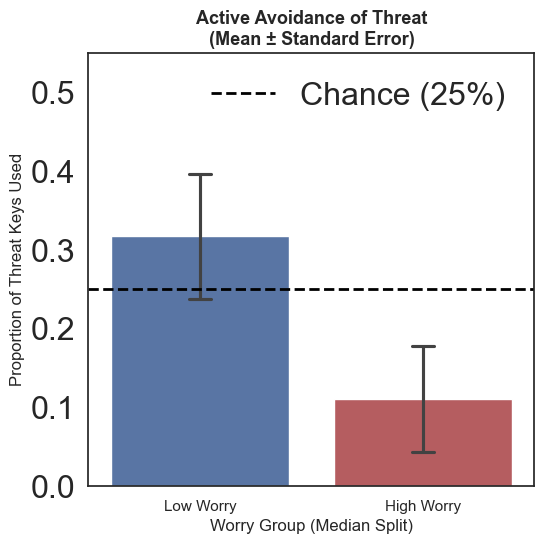

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

# Paths
STUDY2_CSV = Path("game_trials_export.csv")
SUMMARY_CSV = Path("participant-summary.csv")

VALID_KEYS = {
    "small_car": ["a", "d", "w", "x"],
    "big_car": ["s", "f", "e", "c"],
    "small_sedan": ["g", "j", "y", "n"],
    "big_sedan": ["h", "k", "u", "m"],
}

def get_key_category(key):
    for cat, keys in VALID_KEYS.items():
        if key in keys: return cat
    return None

def run_active_avoidance_test():
    # 1. Load Game Data
    if not STUDY2_CSV.exists():
        print(f"Error: {STUDY2_CSV} not found.")
        return
    
    df = pd.read_csv(STUDY2_CSV)
    df = df[df['phase'] == 2].copy() # Planning Phase Only

    # 2. Load and Prepare Group Data
    if not SUMMARY_CSV.exists():
        print(f"Error: {SUMMARY_CSV} not found.")
        return

    print("Loading participant summary...")
    df_sum = pd.read_csv(SUMMARY_CSV)
    
    # Standardize ID column name
    if 'participant' in df_sum.columns:
        df_sum = df_sum.rename(columns={'participant': 'prolificId'})

    # Ensure we have the necessary columns
    # If 'worry_grouped' exists, use it. Otherwise, calculate median split on 'worry'.
    if 'worry_grouped' not in df_sum.columns:
        median_worry = df_sum['worry'].median()
        df_sum['worry_grouped'] = df_sum['worry'].apply(
            lambda x: 'high' if x >= median_worry else 'low'
        )
        print(f"Calculated median split (Median = {median_worry})")

    df_scores = df_sum[['prolificId', 'worry_grouped', 'worry']]

    # 3. Merge Data
    df['prolificId'] = df['prolificId'].astype(str)
    df_scores['prolificId'] = df_scores['prolificId'].astype(str)
    
    # Inner join to keep only participants with survey data
    df = pd.merge(df, df_scores, on='prolificId', how='inner') 

    # 4. Calculate Threat Usage Per Participant
    results = []
    
    # Group by participant to get subject-specific means
    for pid, group in df.groupby('prolificId'):
        worry_group = group['worry_grouped'].iloc[0].lower()
        danger_veh = str(group['dangerous_vehicle'].iloc[0]).lower()
        
        # Identify Threat Category for this specific participant
        threat_cat = None
        for cat in VALID_KEYS:
            if cat in danger_veh.lower().replace(" ", "_"):
                threat_cat = cat
                break
        
        if not threat_cat: continue

        threat_keys = 0
        total_base_keys = 0
        
        # Iterate through planning sequences
        for seq in group['plan_seq']:
            if not isinstance(seq, str): continue
            
            # Extract valid alphabet keys
            keys = [k.lower() for k in seq if k.isalpha()]
            
            for k in keys:
                k_cat = get_key_category(k)
                if k_cat: 
                    total_base_keys += 1
                    if k_cat == threat_cat:
                        threat_keys += 1
        
        # Calculate percentage for this subject
        if total_base_keys > 0:
            usage = threat_keys / total_base_keys
            results.append({
                'prolificId': pid, 
                'group': worry_group, 
                'threat_usage': usage
            })

    res_df = pd.DataFrame(results)

    # 5. Statistical Analysis
    print("\n" + "="*30)
    print("RESULTS: Active Avoidance (Threat Usage)")
    print("="*30)

    # Separate groups
    high_worry = res_df[res_df['group'] == 'high']['threat_usage']
    low_worry = res_df[res_df['group'] == 'low']['threat_usage']

    # Calculate Descriptives (Mean & SE)
    mean_high, se_high = high_worry.mean(), high_worry.sem()
    mean_low, se_low = low_worry.mean(), low_worry.sem()

    print(f"High Worry (N={len(high_worry)}): {mean_high:.2%} ± {se_high:.2%} (SE)")
    print(f"Low Worry  (N={len(low_worry)}): {mean_low:.2%} ± {se_low:.2%} (SE)")

    # T-Tests against Chance (0.25)
    t_high, p_high = stats.ttest_1samp(high_worry, 0.25)
    t_low, p_low = stats.ttest_1samp(low_worry, 0.25)

    print("-" * 30)
    print(f"High vs Chance (25%): t={t_high:.3f}, p={p_high:.4f}")
    print(f"Low vs Chance (25%):  t={t_low:.3f}, p={p_low:.4f}")

    # T-Test between groups (Optional but recommended)
    t_ind, p_ind = stats.ttest_ind(high_worry, low_worry)
    print(f"High vs Low Difference: t={t_ind:.3f}, p={p_ind:.4f}")

    # 6. Visualization
    plt.figure(figsize=(6, 6))
    
    # Create Barplot with Standard Error bars
    sns.barplot(
        data=res_df, 
        x='group', 
        y='threat_usage', 
        order=['low', 'high'], 
        capsize=0.1,
        errorbar='se',  # <--- Changed from None to 'se'
        palette=['#4c72b0', '#c44e52'] # Optional: Blue/Red distinction
    )

    plt.axhline(0.25, color='black', linestyle='--', linewidth=2, label='Chance (25%)')
    plt.ylabel("Proportion of Threat Keys Used", fontsize=12)
    plt.xlabel("Worry Group (Median Split)", fontsize=12)
    plt.xticks([0, 1], ['Low Worry', 'High Worry'], fontsize=11)
    plt.title("Active Avoidance of Threat\n(Mean ± Standard Error)", fontsize=13, fontweight='bold')
    plt.ylim(0, 0.55) 
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig("active_avoidance_plot.png", dpi=300, bbox_inches='tight')
    plt.show()

# Run the function
if __name__ == "__main__":
    run_active_avoidance_test()